# Condition Monitoring of Air Pressure Systems (APS) In Large Vehicles

## Introduction

In most countries, trucks and busses have the highest fatalities in proportion to the number of accident involvements. As such, there is growing pressure on trucking and bus companies to improve their safety measures. The most critical of these safety measures is the maintenance of the Air Pressure System (APS) which controls the braking and gear changes of large vehicles. In this notebook we will apply several machine learning techniques to classify the condition of an APS system to determine if it is at risk of failure.

## Considerations

1. There is an associated cost in performing the maintenance, as such we must also take into account the number of false positives in the result of the model.

## Scope and Limitations

1. Variables used in the dataset are masked as it is proprietary data.

## Import Packages

In [1]:
import eif
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pickle as pkl
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from lightgbm import Dataset
from sklearn.metrics import roc_auc_score
import random

## Define Functions

In [2]:
def apply_log(value):
    if np.isnan(value):
        return value
    else:
        return np.log1p(value)
    
def rescale(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: apply_log(x))
    
    return df

def load_data(filename):
    df = pd.read_csv(filename)
    df = df.replace('na', np.nan)
    df = df.replace('neg', 0)
    df = df.replace('pos', 1)
    df = df.astype(float)
    print(df.shape)
    display(df.head())
    
    return df

def get_label(probability, thresh):
    if probability < thresh:
        return 0
    else:
        return 1

## The Data

### Training Set

In [3]:
df_train = load_data('aps_failure_training_set.csv')

(60000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### Test Set

In [4]:
df_test = load_data('aps_failure_test_set.csv')

(16000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0.0,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0.0,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0.0,59816.0,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0.0,1814.0,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


## Exploratory Data Analysis and Cleaning

### Class Label Distribution

The labels of the dataset is unbalanced, wherein there are only 1000 instances of near failures out of 60000 samples. We thus need to balance the dataset either through oversampling of the minority class or undersampling of the majority class. In addition, we can only use the AUC, F1, precision and recall to evaluate the performance of our model.

1000


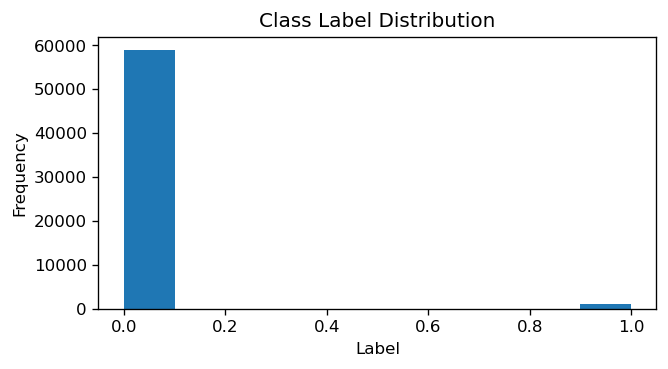

In [5]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
df_train['class'].hist(ax=ax)
ax.set_title('Class Label Distribution')
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.grid()
print(df_train[df_train['class']>0].shape[0])

### Null Handling

The data contains several null values, with some columns being comprised of more than 50% nulls. Since the variables are masked, there's no way for us to know what these variables mean, nor if there's any causality with the target variable. Imputing such a high percentage of unkown values is especially dangerous in the context of APS predictive maintenance.

Text(0.5, 0, 'Percentage')

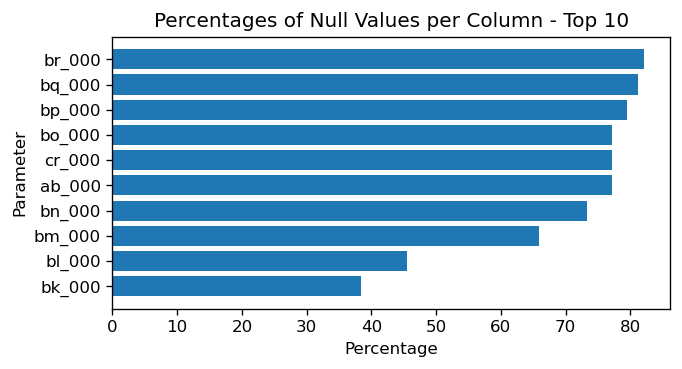

In [6]:
null_stats = (100*df_train.isnull().sum(axis=0)/df_train.shape[0]).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.barh(null_stats.iloc[-10:].index, null_stats.iloc[-10:])
ax.set_title('Percentages of Null Values per Column - Top 10')
ax.set_ylabel('Parameter')
ax.set_xlabel('Percentage')

However, if we were to drop rows / columns just because there are NaN values, we will be dropping a large chunk of our dataset.

In [7]:
print(df_train.dropna(how='any', axis=1).shape)
print(df_train.dropna(how='any').shape)

(60000, 2)
(591, 171)


It seems that the best course of action would be to drop rows / columns that exceed a certain threshold of null quantities. And then impute the values for the remaining cells. The code below shows the distribution of the null percentages along the rows and columns which will aid in identifying an appropriate threshold.

Text(0, 0.5, 'Frequency')

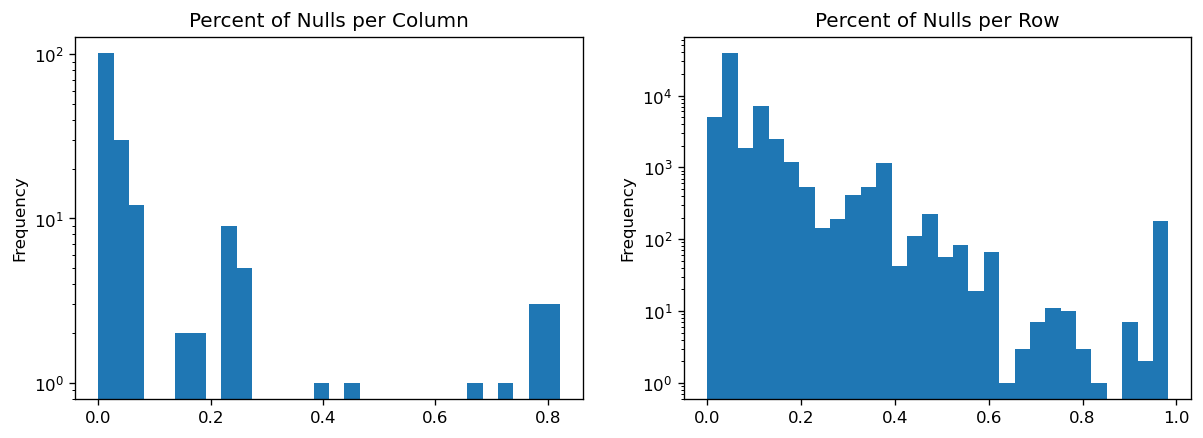

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
(df_train.isnull().sum(axis=0)/df_train.shape[0]).hist(bins=30, ax=ax[0])
(df_train.isnull().sum(axis=1)/df_train.shape[1]).hist(bins=30, ax=ax[1])
ax[0].set_title('Percent of Nulls per Column')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_ylabel('Frequency')
ax[1].set_title('Percent of Nulls per Row')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylabel('Frequency')

A threshold of of 10% for the columns and 40% for the rows seems to be reasonable enough given the distribution. The end result is that we are left with `143` columns (inclusive of the target variable) along with `58329` (out of 59000) rows tagged as 0s and `995` (out of 1000) rows tagged as 1s.

In [9]:
df_cols3 = df_train.isnull().sum(axis=0)/df_train.shape[0]
df_cols3 = df_cols3[df_cols3<0.1]
len(df_cols3.index)

143

In [10]:
Counter(df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]['class'])

Counter({0.0: 58329, 1.0: 995})

In [11]:
df_train = df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]

### Check for Categorical or Continuous Variables

We must check if the variable is categorical or not so that we can apply the appropriate statistical tests. The code below counts the number of unique variables in a dataframe. The higher the count, the more likely it is to be a continuous variable. From here it seems that only `cd_0000` looks to be a categorical variable.

In [12]:
df_nunique = df_train.nunique(axis=0,
                              dropna=False).sort_values(ascending=True)
display(df_nunique.iloc[:10])

class      2
cd_000     2
as_000    21
ef_000    29
dz_000    48
eg_000    50
cs_009    53
au_000    57
ar_000    69
dj_000    73
dtype: int64

Checking `cd_0000` shows that it either has constant or a null value. We will drop this column from the modelling since it doesn't add any onformation due to it being a constant.

In [13]:
list(Counter(df_train['cd_000']).items())[:5]

[(1209600.0, 58842), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [14]:
df_train = df_train.drop('cd_000', axis=1)

### Check Distributions for Normality

Based on `D’Agostino’s K^2` test, it seems that none of our columns follow a normal distribution. This violates the assumption of `pearson's correlation test`. As such, we must use either `spearman's correlation test` or an ML approach with a built in feature importance (e.g. tree-based algorithms) to select which features to use.

In [86]:
from scipy.stats import normaltest

normality = []
for col in df_train.columns:
    
    k2, p = normaltest(df_train[col], nan_policy='omit')
    alpha = 0.05
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        normality.append((col, 'not normal'))
    else:
        normality.append((col, 'normal'))
        
print(f'First 15 columns:\n{normality[:15]}')

First 15 columns:
[('class', 'not normal'), ('aa_000', 'not normal'), ('ac_000', 'not normal'), ('ae_000', 'not normal'), ('af_000', 'not normal'), ('ag_000', 'not normal'), ('ag_001', 'not normal'), ('ag_002', 'not normal'), ('ag_003', 'not normal'), ('ag_004', 'not normal'), ('ag_005', 'not normal'), ('ag_006', 'not normal'), ('ag_007', 'not normal'), ('ag_008', 'not normal'), ('ag_009', 'not normal')]


### Visualization on a Subset of Columns

Majority, of the distributions follow a power law distribution with some variables having exceedingly high values. To address this we will apply log-scaling since other scaling methods will result in a very skewed transformation.

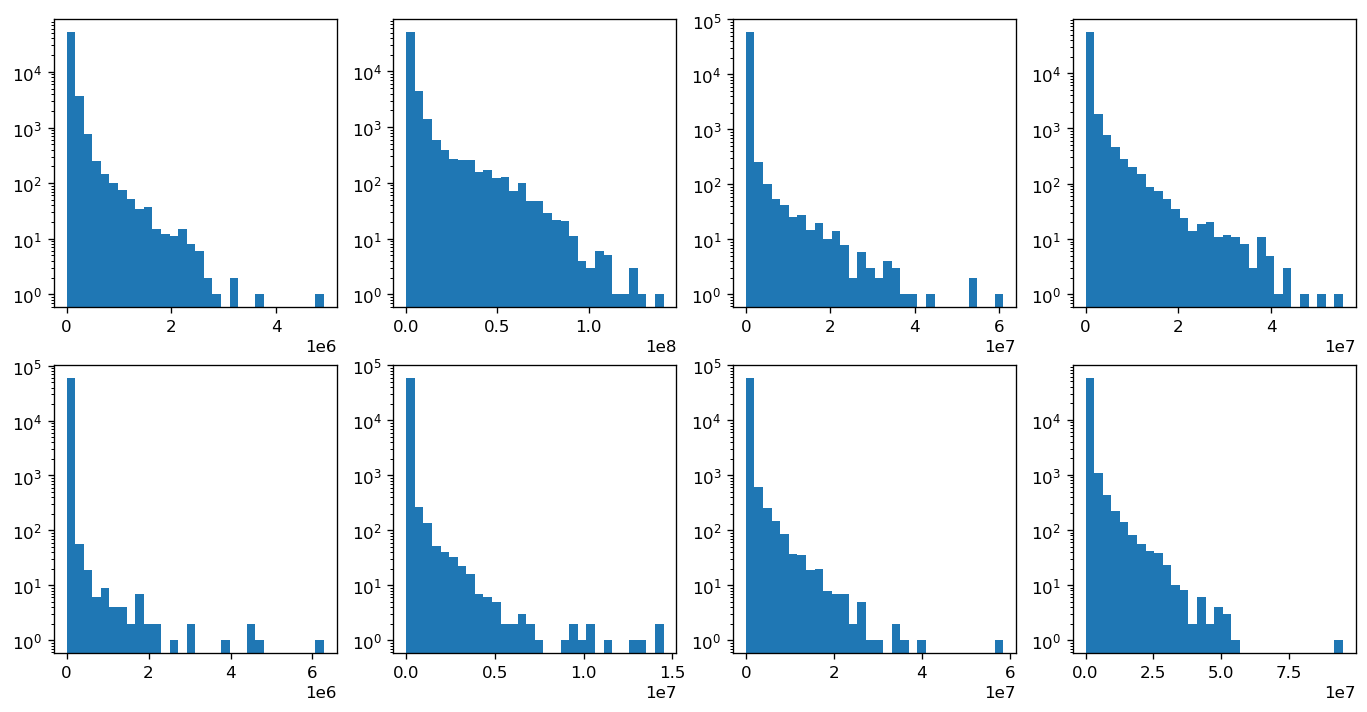

In [16]:
fig, ax = plt.subplots(2,4,figsize=(14,7), dpi=120)
for i, col in enumerate(df_train.columns[80:88]):
    if i < 4:
        j=0
    else:
        j=1
    df_train[col].hist(ax=ax[j][i%4], bins=30)
    ax[j][i%4].set_yscale('log')
    ax[j][i%4].grid()

## Rescaling the Data

The code below executes the log scaling on the features. This is because we have variables that are very large (in the 1000s) that do not have a normal distribution. Log-scaling the data will make it such that the distribution is retained but the value will be smaller. This will greatly help in reducing the scale of the computations for our model. Note that the code below will ignore null values in the transformation.

In [15]:
x = df_train[df_train.columns[1:]]
x = rescale(x)
y = df_train['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Imputing Null Values

Since most of the dataset follows a power law distribution, we will impute the missing values using the mode.

In [16]:
imputer = SimpleImputer(strategy='most_frequent')
x = imputer.fit_transform(x)

## Outlier Analysis

Model performance can be negatively affected by outlying data points. As such it may be useful to analyze the outliers in the data set prior to modelling. Since the data is high dimensional (142 features) we will use an ML approach to checking for outliers.

Extended Isolation Forest algorithm which builds upon Isolation Forest. The advantage of this approach is that it doesn't bisect the hyperplanes one dimension at a time, but rather it bisects the hyperplanes in multiple dimensions at the same time. This solves the issues of imaginary clusters forming up in areas that shouldn't contain data points to begin with. Here's the paper for more details on EIF: https://arxiv.org/pdf/1811.02141.pdf

A `sample_size` of 5000 was chosen to ensure that the distribution is somewhat preserved. The number of tree estimators was set to 125 to ensure that multiple subset of features will be explored by the model. Finally, an `ExtensionLevel` of 71 was chosen such that the model is bisecting the hyperplane 71 dimensions at a time (1/2 of all dimensions). This gives the model some degree of freedom in its bisection. Adding more extension levels does not necessarily improve performance, but it would certainly increase the computational complexity.

In [73]:
eif_71 = eif.iForest(X, ntrees=125, sample_size=5000, ExtensionLevel=71)
anomaly_scores_71 = eif_71.compute_paths(X_in=X)

In [17]:
# with open('anomaly_scores_71.pkl', 'wb') as f:
#     pkl.dump(anomaly_scores_71, f)
    
with open('anomaly_scores_71.pkl','rb') as f:
    anomaly_scores_71 = pkl.load(f)

The frequency distribution of the anomaly scores can be seen below wherein the higher the score the more anomalous the datapoint is. The distribution is positively skewed. Most of the data points have an anomaly score around 0.40.

Text(0.5, 0, 'Anomaly Score')

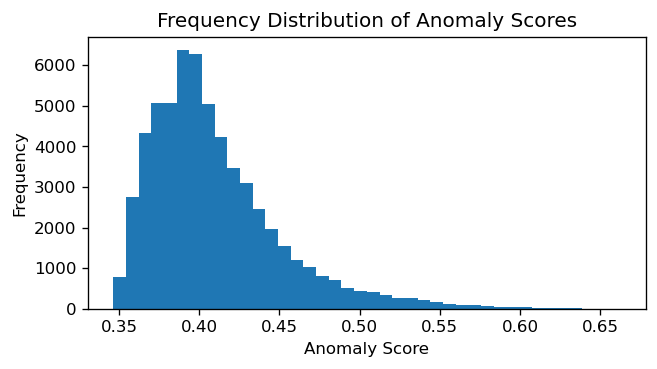

In [23]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.hist(anomaly_scores_71, bins=40)
ax.set_title('Frequency Distribution of Anomaly Scores')
ax.set_ylabel('Frequency')
ax.set_xlabel('Anomaly Score')

The code below extracts all the data points that go beyond an arbitrary outlier threshold that we define. **And it turns out that a good portion of our failure events are outlier cases. Infact, just by setting the threshold to 0.45, we are already able to capture 90% of the outlier cases.** Failure events are supposed to be outliers because if not, then the manufactured product (APS) would be downright unreliable.

While EIF is able to capture a lot of the failure events, we also run the risk of having too many false positives. **If we are to use this model as it is, then more than 10% of our negative cases will be flagged.** This is a costly error in the context of preventive maintenance!

One way to improve the outlier detection model would be to narrow down the features to only the features that are relevant to the particular failure. Luckily, the next model in our pipeline has a built in feature importance.

In [24]:
Counter(y.values[np.where(anomaly_scores_71 > 0.413)])

Counter({0.0: 20793, 1.0: 965})

## Modelling Approaches:

### Approach 1:
1. Remove the outlying points of the majority class.
2. Perform SMOTE on the minority class.
3. Perform supervised machine learning via LGBM.
4. Test the LGBM model on the test set.

### Approach 2: Classifying Outliers
1. Remove the inlying points of the majority class.
2. Perform SMOTE on the minority class.
3. Perform supervised machine learning via LGBM.
4. Test the LGBM model on the test set.

### Approach 3: Stacked EIF and LGBM, Classify Outliers

Down sampling the majority class might remove some of the outlying **normal events**. Which could cause the classifier to classify all outlying events as failing events. The idea to this approach is to remove the inlying normal events (because they are easy enough to identify) and to focus only on separating outlying normal events from the outlying failure events (which are much harder to sort through). An added benefit of this approach is that we also lessen the amount of synthetic data points that we create to balance the dataset.

1. Remove the inlying points of the majority class.
2. Perform SMOTE on the minority class.
3. Perform supervised machine learning via LGBM.
4. Stack the EIF model with the LGBM. Perform the classification only on the outliers.

## Initial Modelling - Approach 2

### Training Set Preparation

In [18]:
# Remove inlying majority class
df_tmp = pd.DataFrame(anomaly_scores_71,
                      columns=['anomaly_score']).join(pd.DataFrame(y.reset_index(drop=True))
                                                      .join(pd.DataFrame(x)))

x_2_0 = df_tmp[(df_tmp['anomaly_score']>0.413)&(df_tmp['class']==0.0)]
x_2_0 = x_2_0[x_2_0.columns[1:]]
x_2_1 = df_tmp[df_tmp['class']==1.0]
x_2_1 = x_2_1[x_2_1.columns[1:]]

# Append then shuffle the data
data_2 = x_2_0.append(x_2_1).sample(frac=1)
x_2 = data_2[data_2.columns[1:]]
y_2 = data_2['class']

# Balance the dataset using SMOTE
sm = SMOTE(random_state=42, n_jobs=-1)
x_res2, y_res2 = sm.fit_resample(x_2, y_2)

### Test Set Preparation

No Inlier Removal, no dropping of rows with many null values.

In [19]:
x_test = df_test[df_train.columns[1:]]
# No droping of rows with many null values

x_test = rescale(x_test)

imputer = SimpleImputer(strategy='most_frequent')
x_test = imputer.fit_transform(x_test)

# No outlier analysis / inlier removal
y_test = df_test['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Hyperparameter Tuning

We will train the Light Gradient Boosted Model (LGBM) on the balanced dataset.

In [271]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1]}

len(list(ParameterGrid(param_grid)))

81

In [272]:
cv_results = []
for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):
    
    validation_summary = lgb.cv(hyperparams,
                                Dataset(x_2, label=y_2),
                                num_boost_round=1500,
                                nfold=10,
                                metrics=["auc"],
                                early_stopping_rounds=25,
                                verbose_eval=25, seed=42)
    
    # Store the best hyperparameters
    cv_results.append((hyperparams, validation_summary["auc-mean"][-1]))
    
    print(i)

[25]	cv_agg's auc: 0.980956 + 0.00762579
[50]	cv_agg's auc: 0.98241 + 0.00891101
[75]	cv_agg's auc: 0.983465 + 0.00913202
[100]	cv_agg's auc: 0.984203 + 0.00910271
[125]	cv_agg's auc: 0.984454 + 0.00912588
[150]	cv_agg's auc: 0.984401 + 0.00931032
0
[25]	cv_agg's auc: 0.980935 + 0.00775844
[50]	cv_agg's auc: 0.982694 + 0.00869713
[75]	cv_agg's auc: 0.98349 + 0.00919205
1
[25]	cv_agg's auc: 0.98068 + 0.0074834
[50]	cv_agg's auc: 0.982894 + 0.00839021
[75]	cv_agg's auc: 0.984274 + 0.00804628
[100]	cv_agg's auc: 0.984735 + 0.00824786
[125]	cv_agg's auc: 0.984954 + 0.0082732
[150]	cv_agg's auc: 0.984856 + 0.00853469
2
[25]	cv_agg's auc: 0.980001 + 0.00822228
[50]	cv_agg's auc: 0.982419 + 0.00877668
[75]	cv_agg's auc: 0.983606 + 0.00902905
[100]	cv_agg's auc: 0.984026 + 0.00900319
[125]	cv_agg's auc: 0.984223 + 0.00902865
3
[25]	cv_agg's auc: 0.980001 + 0.00822228
[50]	cv_agg's auc: 0.982585 + 0.00866007
[75]	cv_agg's auc: 0.9841 + 0.00824606
[100]	cv_agg's auc: 0.984334 + 0.00839326
[125]	

[475]	cv_agg's auc: 0.979029 + 0.0085477
[500]	cv_agg's auc: 0.979237 + 0.00846621
[525]	cv_agg's auc: 0.979495 + 0.00836058
[550]	cv_agg's auc: 0.979719 + 0.00827398
[575]	cv_agg's auc: 0.979936 + 0.0081997
[600]	cv_agg's auc: 0.980098 + 0.00810489
[625]	cv_agg's auc: 0.980251 + 0.00804475
[650]	cv_agg's auc: 0.980389 + 0.0080152
[675]	cv_agg's auc: 0.98049 + 0.00795327
[700]	cv_agg's auc: 0.98058 + 0.00793548
[725]	cv_agg's auc: 0.980674 + 0.00793204
[750]	cv_agg's auc: 0.980752 + 0.00791111
[775]	cv_agg's auc: 0.980844 + 0.00785899
[800]	cv_agg's auc: 0.980941 + 0.00782525
[825]	cv_agg's auc: 0.981038 + 0.00782273
[850]	cv_agg's auc: 0.981101 + 0.00779828
[875]	cv_agg's auc: 0.981181 + 0.00776169
[900]	cv_agg's auc: 0.981268 + 0.00771985
[925]	cv_agg's auc: 0.981322 + 0.00770167
[950]	cv_agg's auc: 0.981389 + 0.00767476
[975]	cv_agg's auc: 0.981446 + 0.00761763
[1000]	cv_agg's auc: 0.981506 + 0.00761153
[1025]	cv_agg's auc: 0.981551 + 0.00758857
[1050]	cv_agg's auc: 0.981571 + 0.007

[850]	cv_agg's auc: 0.981072 + 0.00772842
[875]	cv_agg's auc: 0.981125 + 0.00770103
[900]	cv_agg's auc: 0.981186 + 0.00769591
[925]	cv_agg's auc: 0.981254 + 0.00768148
[950]	cv_agg's auc: 0.981297 + 0.00769094
[975]	cv_agg's auc: 0.981357 + 0.00765407
[1000]	cv_agg's auc: 0.981395 + 0.00764494
[1025]	cv_agg's auc: 0.981413 + 0.00764783
[1050]	cv_agg's auc: 0.981477 + 0.0076444
[1075]	cv_agg's auc: 0.981509 + 0.00762403
[1100]	cv_agg's auc: 0.981542 + 0.00763191
[1125]	cv_agg's auc: 0.981567 + 0.00762862
[1150]	cv_agg's auc: 0.981608 + 0.00762708
[1175]	cv_agg's auc: 0.981641 + 0.00760766
[1200]	cv_agg's auc: 0.981682 + 0.00761546
[1225]	cv_agg's auc: 0.981709 + 0.00759756
[1250]	cv_agg's auc: 0.981724 + 0.00760539
[1275]	cv_agg's auc: 0.981744 + 0.00760127
[1300]	cv_agg's auc: 0.981774 + 0.00759514
[1325]	cv_agg's auc: 0.981796 + 0.00759643
[1350]	cv_agg's auc: 0.981801 + 0.00760356
[1375]	cv_agg's auc: 0.98183 + 0.00759898
[1400]	cv_agg's auc: 0.981857 + 0.00760232
[1425]	cv_agg's auc

[1225]	cv_agg's auc: 0.981542 + 0.00784663
[1250]	cv_agg's auc: 0.981582 + 0.00784421
[1275]	cv_agg's auc: 0.981614 + 0.00782517
[1300]	cv_agg's auc: 0.981673 + 0.00778739
[1325]	cv_agg's auc: 0.981723 + 0.00776561
[1350]	cv_agg's auc: 0.981743 + 0.00778922
[1375]	cv_agg's auc: 0.981739 + 0.00781154
24
[25]	cv_agg's auc: 0.950331 + 0.00799008
[50]	cv_agg's auc: 0.962589 + 0.00866385
[75]	cv_agg's auc: 0.966831 + 0.00819158
[100]	cv_agg's auc: 0.969669 + 0.00853328
[125]	cv_agg's auc: 0.971065 + 0.00882933
[150]	cv_agg's auc: 0.972106 + 0.00912581
[175]	cv_agg's auc: 0.973063 + 0.00930159
[200]	cv_agg's auc: 0.97418 + 0.0092814
[225]	cv_agg's auc: 0.97485 + 0.0093761
[250]	cv_agg's auc: 0.975541 + 0.00937991
[275]	cv_agg's auc: 0.976179 + 0.00928465
[300]	cv_agg's auc: 0.976734 + 0.00916121
[325]	cv_agg's auc: 0.977173 + 0.00907772
[350]	cv_agg's auc: 0.977488 + 0.00900053
[375]	cv_agg's auc: 0.977761 + 0.00891802
[400]	cv_agg's auc: 0.97801 + 0.00887639
[425]	cv_agg's auc: 0.978294 + 0

37
[25]	cv_agg's auc: 0.973425 + 0.00790831
[50]	cv_agg's auc: 0.977596 + 0.00833666
[75]	cv_agg's auc: 0.979487 + 0.00884823
[100]	cv_agg's auc: 0.98122 + 0.00836066
[125]	cv_agg's auc: 0.982052 + 0.0083749
[150]	cv_agg's auc: 0.982826 + 0.00808799
[175]	cv_agg's auc: 0.983211 + 0.00811511
[200]	cv_agg's auc: 0.983456 + 0.00816385
[225]	cv_agg's auc: 0.983641 + 0.00814727
[250]	cv_agg's auc: 0.983918 + 0.00809804
[275]	cv_agg's auc: 0.984036 + 0.00809768
[300]	cv_agg's auc: 0.984114 + 0.00812011
[325]	cv_agg's auc: 0.984276 + 0.00807859
[350]	cv_agg's auc: 0.984312 + 0.00803089
[375]	cv_agg's auc: 0.984337 + 0.00800569
[400]	cv_agg's auc: 0.984383 + 0.00796574
[425]	cv_agg's auc: 0.984404 + 0.0080433
38
[25]	cv_agg's auc: 0.972965 + 0.00817635
[50]	cv_agg's auc: 0.977536 + 0.00847784
[75]	cv_agg's auc: 0.979779 + 0.00845508
[100]	cv_agg's auc: 0.981114 + 0.00844913
[125]	cv_agg's auc: 0.981872 + 0.00839347
[150]	cv_agg's auc: 0.982396 + 0.00855459
[175]	cv_agg's auc: 0.982836 + 0.0084

[850]	cv_agg's auc: 0.981101 + 0.00779828
[875]	cv_agg's auc: 0.981184 + 0.00776552
[900]	cv_agg's auc: 0.981264 + 0.00771601
[925]	cv_agg's auc: 0.981323 + 0.00770277
[950]	cv_agg's auc: 0.981388 + 0.00767311
[975]	cv_agg's auc: 0.981448 + 0.00761982
[1000]	cv_agg's auc: 0.981501 + 0.00760608
[1025]	cv_agg's auc: 0.981545 + 0.00758207
[1050]	cv_agg's auc: 0.981567 + 0.00759098
[1075]	cv_agg's auc: 0.981604 + 0.00759363
[1100]	cv_agg's auc: 0.981628 + 0.00759532
[1125]	cv_agg's auc: 0.981646 + 0.00760331
[1150]	cv_agg's auc: 0.981695 + 0.00759932
[1175]	cv_agg's auc: 0.981735 + 0.00759163
[1200]	cv_agg's auc: 0.981757 + 0.00757813
[1225]	cv_agg's auc: 0.981798 + 0.00757481
[1250]	cv_agg's auc: 0.981813 + 0.00756867
[1275]	cv_agg's auc: 0.981835 + 0.00757314
[1300]	cv_agg's auc: 0.981855 + 0.00756635
[1325]	cv_agg's auc: 0.981879 + 0.00756688
[1350]	cv_agg's auc: 0.981907 + 0.00755598
[1375]	cv_agg's auc: 0.981929 + 0.00755849
[1400]	cv_agg's auc: 0.981944 + 0.00756325
[1425]	cv_agg's a

[1250]	cv_agg's auc: 0.981742 + 0.00758959
[1275]	cv_agg's auc: 0.981745 + 0.00760162
[1300]	cv_agg's auc: 0.981762 + 0.00761053
[1325]	cv_agg's auc: 0.981777 + 0.00762979
[1350]	cv_agg's auc: 0.981788 + 0.00763072
[1375]	cv_agg's auc: 0.981817 + 0.00762324
[1400]	cv_agg's auc: 0.981845 + 0.00760586
[1425]	cv_agg's auc: 0.981856 + 0.0076221
[1450]	cv_agg's auc: 0.98188 + 0.00762275
[1475]	cv_agg's auc: 0.981876 + 0.00762918
[1500]	cv_agg's auc: 0.981897 + 0.00762879
49
[25]	cv_agg's auc: 0.950297 + 0.00724833
[50]	cv_agg's auc: 0.962448 + 0.00823218
[75]	cv_agg's auc: 0.966537 + 0.00839763
[100]	cv_agg's auc: 0.969694 + 0.0084749
[125]	cv_agg's auc: 0.971507 + 0.00848892
[150]	cv_agg's auc: 0.973034 + 0.00828765
[175]	cv_agg's auc: 0.973746 + 0.00854538
[200]	cv_agg's auc: 0.974377 + 0.00895104
[225]	cv_agg's auc: 0.975017 + 0.00909841
[250]	cv_agg's auc: 0.975678 + 0.00911023
[275]	cv_agg's auc: 0.976225 + 0.00912327
[300]	cv_agg's auc: 0.976756 + 0.00901541
[325]	cv_agg's auc: 0.9773

[375]	cv_agg's auc: 0.977761 + 0.00891802
[400]	cv_agg's auc: 0.97801 + 0.00887639
[425]	cv_agg's auc: 0.978294 + 0.00880459
[450]	cv_agg's auc: 0.97855 + 0.00870159
[475]	cv_agg's auc: 0.97875 + 0.00866889
[500]	cv_agg's auc: 0.978987 + 0.00858071
[525]	cv_agg's auc: 0.979217 + 0.00851372
[550]	cv_agg's auc: 0.979439 + 0.00843815
[575]	cv_agg's auc: 0.979591 + 0.00840897
[600]	cv_agg's auc: 0.979776 + 0.0083649
[625]	cv_agg's auc: 0.979894 + 0.00829591
[650]	cv_agg's auc: 0.979996 + 0.0082718
[675]	cv_agg's auc: 0.980132 + 0.00824066
[700]	cv_agg's auc: 0.980237 + 0.00818621
[725]	cv_agg's auc: 0.980373 + 0.00815266
[750]	cv_agg's auc: 0.980475 + 0.0081313
[775]	cv_agg's auc: 0.980583 + 0.00811337
[800]	cv_agg's auc: 0.980655 + 0.00808796
[825]	cv_agg's auc: 0.980715 + 0.00807663
[850]	cv_agg's auc: 0.980791 + 0.008064
[875]	cv_agg's auc: 0.980869 + 0.00803633
[900]	cv_agg's auc: 0.980917 + 0.00803165
[925]	cv_agg's auc: 0.98098 + 0.00801266
[950]	cv_agg's auc: 0.981025 + 0.00800635
[

[300]	cv_agg's auc: 0.983693 + 0.0081786
[325]	cv_agg's auc: 0.983768 + 0.0082304
[350]	cv_agg's auc: 0.983801 + 0.00814123
[375]	cv_agg's auc: 0.983962 + 0.00805194
[400]	cv_agg's auc: 0.984024 + 0.00805584
69
[25]	cv_agg's auc: 0.971797 + 0.00799038
[50]	cv_agg's auc: 0.976988 + 0.00926886
[75]	cv_agg's auc: 0.978732 + 0.00940309
[100]	cv_agg's auc: 0.980326 + 0.00915974
[125]	cv_agg's auc: 0.981283 + 0.0089291
[150]	cv_agg's auc: 0.982021 + 0.00872634
[175]	cv_agg's auc: 0.982598 + 0.0085199
[200]	cv_agg's auc: 0.982977 + 0.00835111
[225]	cv_agg's auc: 0.98329 + 0.00828283
[250]	cv_agg's auc: 0.983466 + 0.00828163
[275]	cv_agg's auc: 0.983583 + 0.0082373
[300]	cv_agg's auc: 0.983693 + 0.0081786
[325]	cv_agg's auc: 0.983768 + 0.0082304
[350]	cv_agg's auc: 0.983801 + 0.00814123
[375]	cv_agg's auc: 0.983962 + 0.00805194
[400]	cv_agg's auc: 0.984024 + 0.00805584
70
[25]	cv_agg's auc: 0.971797 + 0.00799038
[50]	cv_agg's auc: 0.976989 + 0.00926968
[75]	cv_agg's auc: 0.978751 + 0.009419
[1

[1075]	cv_agg's auc: 0.981554 + 0.0076299
[1100]	cv_agg's auc: 0.981574 + 0.00764849
[1125]	cv_agg's auc: 0.981598 + 0.00765987
[1150]	cv_agg's auc: 0.981656 + 0.0076469
[1175]	cv_agg's auc: 0.981693 + 0.00764206
[1200]	cv_agg's auc: 0.981713 + 0.00764067
[1225]	cv_agg's auc: 0.981727 + 0.00763363
[1250]	cv_agg's auc: 0.981754 + 0.00763212
[1275]	cv_agg's auc: 0.981777 + 0.00762807
[1300]	cv_agg's auc: 0.981813 + 0.00761737
[1325]	cv_agg's auc: 0.981833 + 0.00761201
[1350]	cv_agg's auc: 0.981852 + 0.0076053
[1375]	cv_agg's auc: 0.981872 + 0.00762308
[1400]	cv_agg's auc: 0.981893 + 0.00763015
[1425]	cv_agg's auc: 0.981906 + 0.00762321
[1450]	cv_agg's auc: 0.98192 + 0.00762358
[1475]	cv_agg's auc: 0.981946 + 0.00762465
[1500]	cv_agg's auc: 0.981953 + 0.00762608
74
[25]	cv_agg's auc: 0.950297 + 0.00724833
[50]	cv_agg's auc: 0.962448 + 0.00823218
[75]	cv_agg's auc: 0.966536 + 0.00839829
[100]	cv_agg's auc: 0.969694 + 0.0084749
[125]	cv_agg's auc: 0.971507 + 0.00848892
[150]	cv_agg's auc: 0

[1450]	cv_agg's auc: 0.981974 + 0.00748823
[1475]	cv_agg's auc: 0.98199 + 0.0074965
[1500]	cv_agg's auc: 0.981986 + 0.00750736
77
[25]	cv_agg's auc: 0.950331 + 0.00799008
[50]	cv_agg's auc: 0.962589 + 0.00866385
[75]	cv_agg's auc: 0.966831 + 0.00819158
[100]	cv_agg's auc: 0.969669 + 0.00853328
[125]	cv_agg's auc: 0.971065 + 0.00882933
[150]	cv_agg's auc: 0.972106 + 0.00912581
[175]	cv_agg's auc: 0.973063 + 0.00930159
[200]	cv_agg's auc: 0.97418 + 0.0092814
[225]	cv_agg's auc: 0.97485 + 0.0093761
[250]	cv_agg's auc: 0.975539 + 0.00937905
[275]	cv_agg's auc: 0.976181 + 0.00928554
[300]	cv_agg's auc: 0.976698 + 0.00922444
[325]	cv_agg's auc: 0.977187 + 0.00906852
[350]	cv_agg's auc: 0.977468 + 0.0090383
[375]	cv_agg's auc: 0.977767 + 0.00894381
[400]	cv_agg's auc: 0.978015 + 0.00888043
[425]	cv_agg's auc: 0.978302 + 0.00879066
[450]	cv_agg's auc: 0.978553 + 0.008694
[475]	cv_agg's auc: 0.978759 + 0.00866142
[500]	cv_agg's auc: 0.978939 + 0.0086228
[525]	cv_agg's auc: 0.979137 + 0.00858908

In [21]:
# with open('cv.pkl', 'wb') as f:
#     pkl.dump(sorted(cv_results, key=lambda x: x[1], reverse=True), f)
with open('cv.pkl', 'rb') as f:
    cv_results = pkl.load(f)

In [22]:
params = cv_results[0][0]
params['metric'] = ["auc"]
params['num_boost_round'] = 1500
params['nfold'] = 10
params['early_stopping_rounds'] = 25
params['verbose_eval'] = 25

In [26]:
# Split Use 3 Validation Sets From Training Set
train_index = random.sample(range(x_2.shape[0]), 10000)
val_index = list(set(range(x_2.shape[0])).difference(train_index))
random.shuffle(val_index)
validation_sets = [Dataset(x_2.values[val_index[x::3]],
                           label=y_2.values[val_index[x::3]])
                   for x in range(3)]

# Model
lgbm_model = lgb.train(params, Dataset(x_2.values[train_index],
                                       label=y_2.values[train_index]),
                       valid_sets=validation_sets)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.94349	valid_1's auc: 0.955619	valid_2's auc: 0.943471
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.956014	valid_1's auc: 0.966956	valid_2's auc: 0.957236
[3]	valid_0's auc: 0.961912	valid_1's auc: 0.971465	valid_2's auc: 0.965579
[4]	valid_0's auc: 0.963644	valid_1's auc: 0.973201	valid_2's auc: 0.966832
[5]	valid_0's auc: 0.964893	valid_1's auc: 0.975023	valid_2's auc: 0.970529
[6]	valid_0's auc: 0.966346	valid_1's auc: 0.976562	valid_2's auc: 0.971912
[7]	valid_0's auc: 0.966165	valid_1's auc: 0.977095	valid_2's auc: 0.972242
[8]	valid_0's auc: 0.96929	valid_1's auc: 0.978132	valid_2's auc: 0.974994
[9]	valid_0's auc: 0.970099	valid_1's auc: 0.978688	valid_2's auc: 0.975461
[10]	valid_0's auc: 0.974664	valid_1's auc: 0.97885	valid_2's auc: 0.975794
[11]	valid_0's auc: 0.975265	valid_1's auc: 0.979313	valid_2's auc: 0.975682
[12]	valid_0's auc: 0.975746	valid_1's auc: 0.979664	valid_2's auc: 0.975837
[13]	valid_0's auc: 0.97629

### Training Set Validation
#### AUC Score

In [34]:
y_pred = lgbm_model.predict(x_2)
print(roc_auc_score(y_2, y_pred))

0.9860126148947982


#### F1 Plot

Text(0.5, 1.0, 'F1 Across Thresholds')

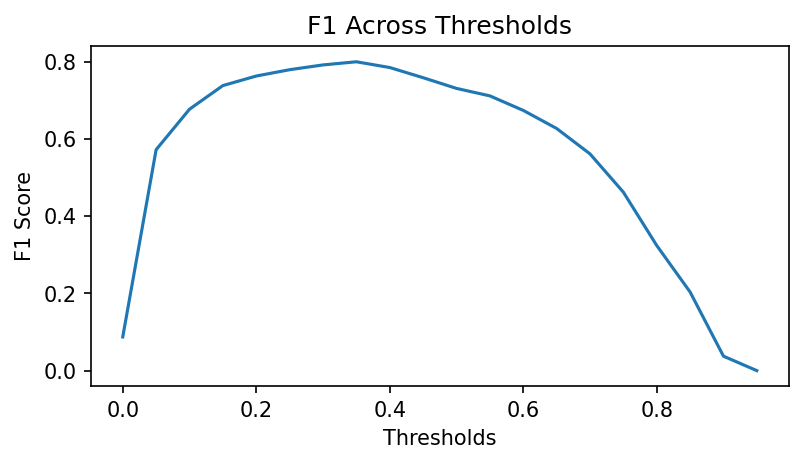

In [35]:
f1s = []

for thresh in range(0,100,5):
    y_pred_labels = list(map(lambda x: get_label(x, thresh/100), y_pred))
    f1s.append(f1_score(y_true=y_2,y_pred=y_pred_labels))

fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.plot(np.array(range(0,100,5))/100, f1s)
ax.set_ylabel('F1 Score')
ax.set_xlabel('Thresholds')
ax.set_title('F1 Across Thresholds')

#### Confusion Matrix at 0.2 Threshold

In [36]:
y_pred_labels = list(map(lambda x: get_label(x, 0.2), y_pred))
print(f1_score(y_true=y_2,y_pred=y_pred_labels))
confusion_matrix(y_true=y_2,y_pred=y_pred_labels)

0.7634927599824485


array([[20379,   414],
       [  125,   870]], dtype=int64)

### Test Set Validation

#### AUC Score

In [37]:
y_pred = lgbm_model.predict(x_test)
print(roc_auc_score(y_test, y_pred))

0.9933621759999999


#### F1 Plot

Text(0.5, 1.0, 'F1 Across Thresholds')

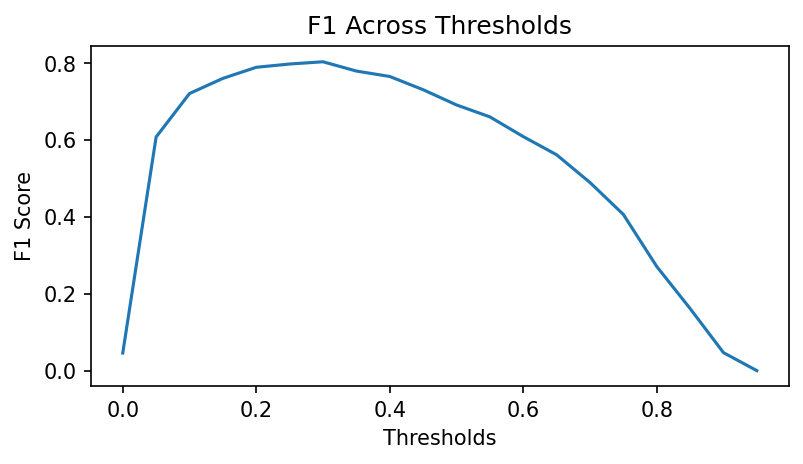

In [38]:
f1s = []

for thresh in range(0,100,5):
    y_pred_labels = list(map(lambda x: get_label(x, thresh/100), y_pred))
    f1s.append(f1_score(y_true=y_test,y_pred=y_pred_labels))

fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.plot(np.array(range(0,100,5))/100, f1s)
ax.set_ylabel('F1 Score')
ax.set_xlabel('Thresholds')
ax.set_title('F1 Across Thresholds')

#### Confusion Matrix at 0.2 Threshold

In [39]:
y_pred_labels = list(map(lambda x: get_label(x, 0.2), y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred_labels))
confusion_matrix(y_true=y_test,y_pred=y_pred_labels)

0.7899159663865545


array([[15496,   129],
       [   46,   329]], dtype=int64)

### Feature Importance

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


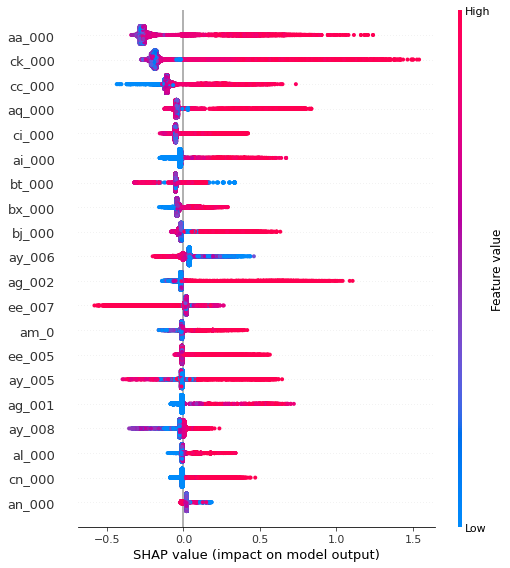

In [50]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(x_2)

df_x2 = pd.DataFrame(x_2)
df_x2.columns=df_train.columns[1:]

shap.summary_plot(shap_values[1], df_x2)

#### SHAP Value Distribution per Predictor

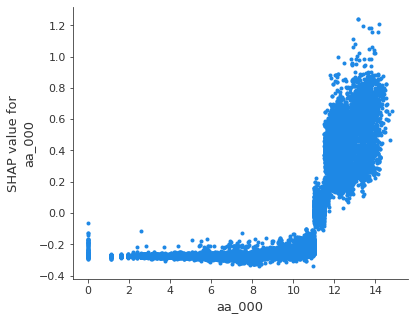

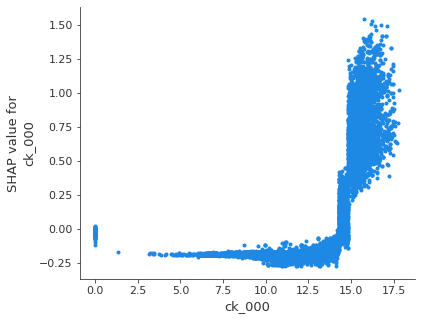

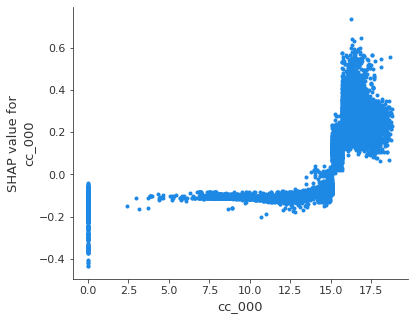

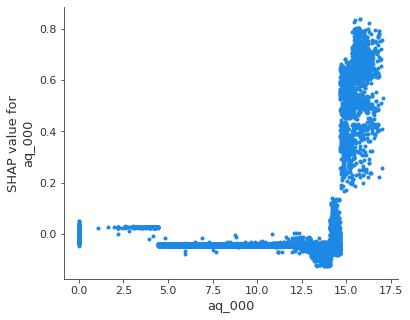

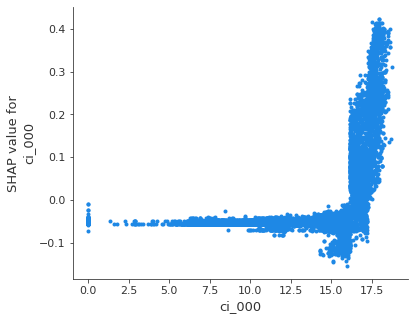

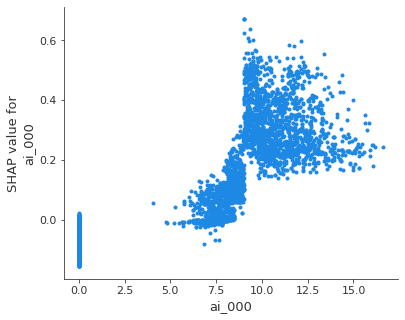

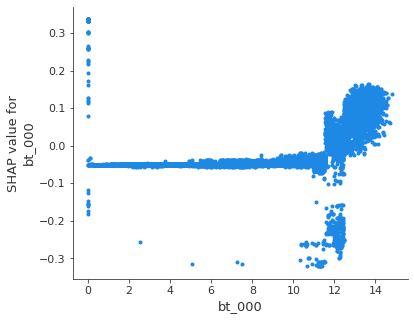

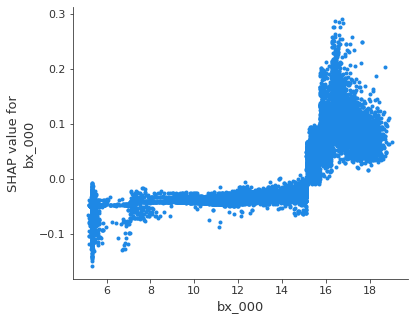

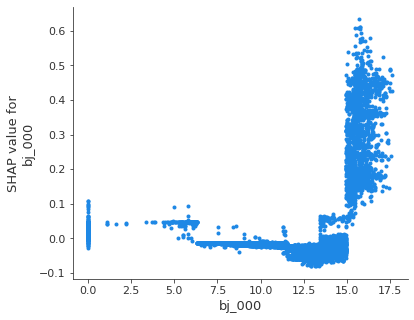

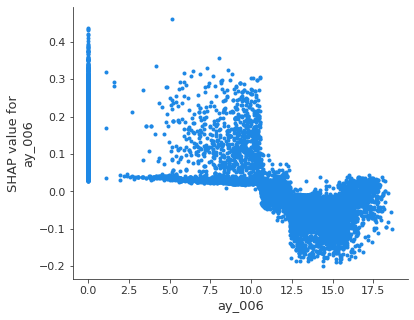

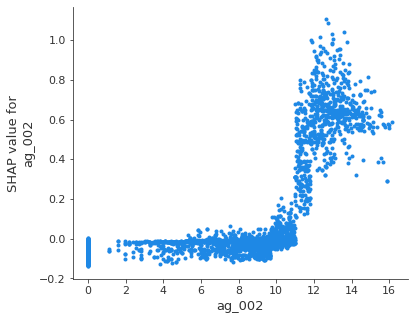

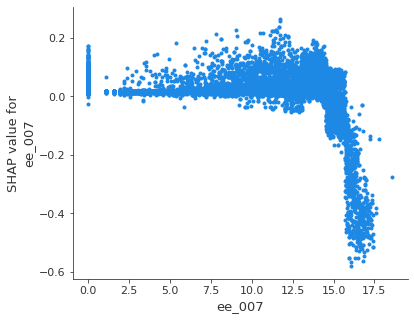

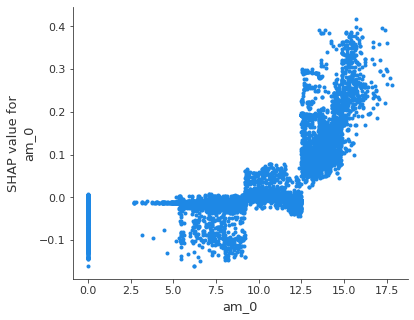

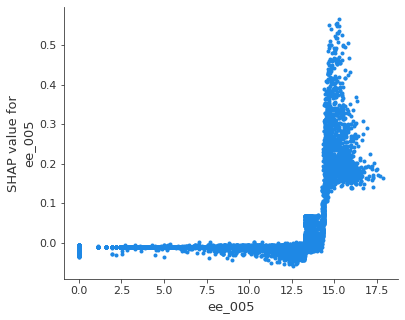

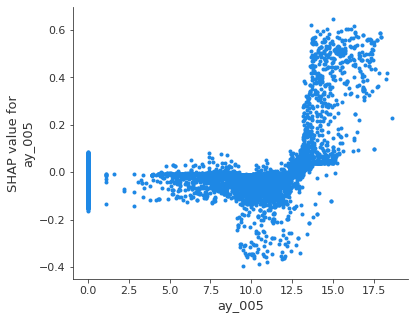

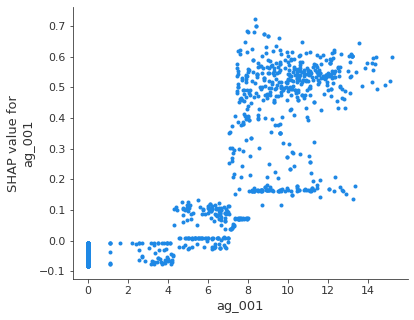

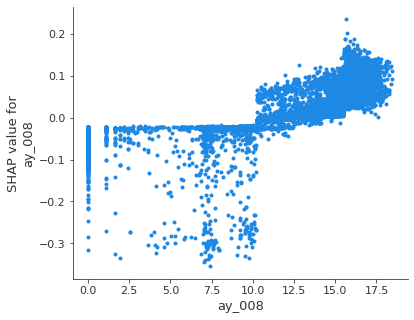

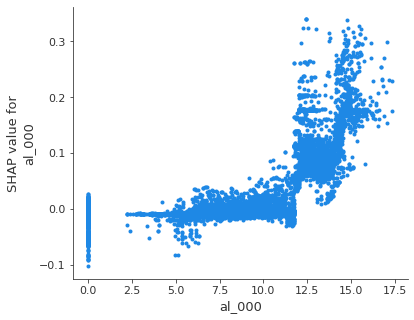

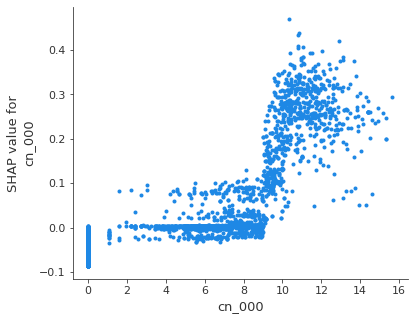

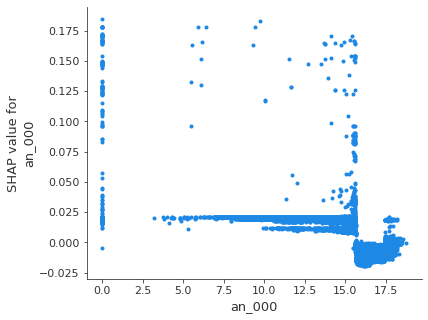

In [52]:
top_feats = ['aa_000','ck_000','cc_000','aq_000',
             'ci_000', 'ai_000','bt_000', 'bx_000',
             'bj_000', 'ay_006', 'ag_002', 'ee_007',
             'am_0', 'ee_005', 'ay_005', 'ag_001',
             'ay_008', 'al_000', 'cn_000', 'an_000']
for feat in top_feats:
    shap.dependence_plot(feat, shap_values[1], df_x2, interaction_index=None)

## Re-Modelling Using Less Features

In [54]:
validation_sets = [Dataset(df_x2[top_feats].values[val_index[x::3]],
                           label=y_2.values[val_index[x::3]])
                   for x in range(3)]

lgbm_model = lgb.train(params, Dataset(df_x2[top_feats].values[train_index],
                                       label=y_2.values[train_index]),
                       valid_sets=validation_sets)

[1]	valid_0's auc: 0.939711	valid_1's auc: 0.947968	valid_2's auc: 0.942962
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.955399	valid_1's auc: 0.962585	valid_2's auc: 0.95949
[3]	valid_0's auc: 0.960488	valid_1's auc: 0.971491	valid_2's auc: 0.965735
[4]	valid_0's auc: 0.963428	valid_1's auc: 0.973839	valid_2's auc: 0.96769
[5]	valid_0's auc: 0.964776	valid_1's auc: 0.975502	valid_2's auc: 0.968773
[6]	valid_0's auc: 0.965133	valid_1's auc: 0.976026	valid_2's auc: 0.968988
[7]	valid_0's auc: 0.965399	valid_1's auc: 0.976691	valid_2's auc: 0.969386
[8]	valid_0's auc: 0.965798	valid_1's auc: 0.977165	valid_2's auc: 0.969874
[9]	valid_0's auc: 0.966451	valid_1's auc: 0.977647	valid_2's auc: 0.97027
[10]	valid_0's auc: 0.966636	valid_1's auc: 0.978098	valid_2's auc: 0.970752
[11]	valid_0's auc: 0.967077	valid_1's auc: 0.978583	valid_2's auc: 0.971067
[12]	valid_0's auc: 0.967867	valid_1's auc: 0.979391	valid_2's auc: 0.971488
[13]	valid_0's auc: 0.97052

### Training Set Validation

#### AUC Score

In [57]:
y_pred = lgbm_model.predict(df_x2[top_feats].values)
print(roc_auc_score(y_2, y_pred))

0.9875465917090864


#### F1 Plot

Text(0.5, 1.0, 'F1 Across Thresholds')

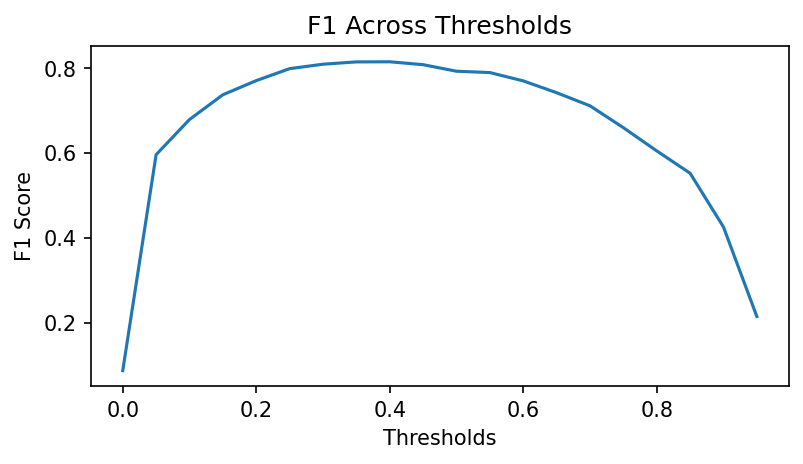

In [58]:
f1s = []
for thresh in range(0,100,5):
    y_pred_labels = list(map(lambda x: get_label(x, thresh/100), y_pred))
    f1s.append(f1_score(y_true=y_2,y_pred=y_pred_labels))

fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.plot(np.array(range(0,100,5))/100, f1s)
ax.set_ylabel('F1 Score')
ax.set_xlabel('Thresholds')
ax.set_title('F1 Across Thresholds')

#### Confusion Matrix at 0.2

In [59]:
y_pred_labels = list(map(lambda x: get_label(x, 0.2), y_pred))
print(f1_score(y_true=y_2,y_pred=y_pred_labels))
confusion_matrix(y_true=y_2,y_pred=y_pred_labels)

0.7714285714285714


array([[20369,   424],
       [  104,   891]], dtype=int64)

### Test Set Validation

In [64]:
df_xt = pd.DataFrame(x_test)
df_xt.columns = df_train.columns[1:]
y_pred = lgbm_model.predict(df_xt[top_feats].values)
print(roc_auc_score(y_test, y_pred))

0.9914740053333333


Text(0.5, 1.0, 'F1 Across Thresholds')

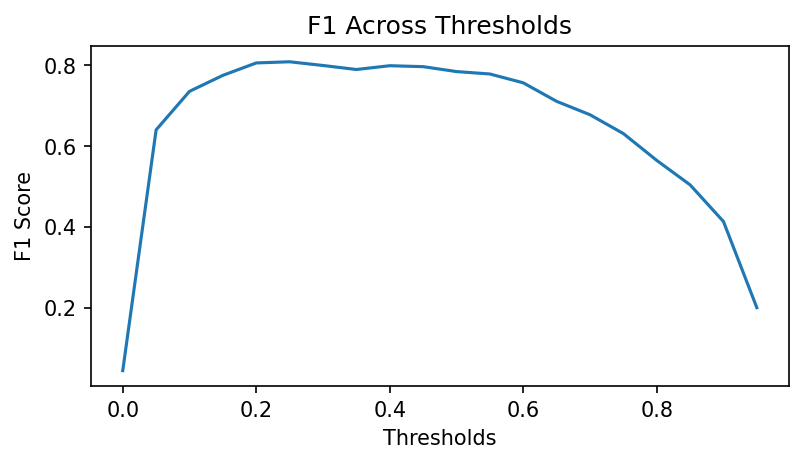

In [66]:
f1s = []
for thresh in range(0,100,5):
    y_pred_labels = list(map(lambda x: get_label(x, thresh/100), y_pred))
    f1s.append(f1_score(y_true=y_test,y_pred=y_pred_labels))

fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.plot(np.array(range(0,100,5))/100, f1s)
ax.set_ylabel('F1 Score')
ax.set_xlabel('Thresholds')
ax.set_title('F1 Across Thresholds')

In [67]:
y_pred_labels = list(map(lambda x: get_label(x, 0.2), y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred_labels))
confusion_matrix(y_true=y_test,y_pred=y_pred_labels)

0.8062953995157386


array([[15507,   118],
       [   42,   333]], dtype=int64)

# SCRATCH

In [46]:
np.random.seed(1)

kf_data = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_res3, y=y_res3)

param_grid = {
    'num_leaves': [31,41,51],
    'min_data_in_leaf': [75, 100,125],
    'lambda_l1': [0.0001,0.001, 0.01],
    'lambda_l2': [0.1,1,10]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                   objective='binary',
                                   num_boost_round=250,
                                   learning_rate=0.1,
                                   metric='auc')

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=kf_data)
lgb_model = gsearch.fit(X=X_res3, y=y_res3)

print(lgb_model.best_params_, lgb_model.best_score_)

C:\Users\Nigel\anaconda3\envs\smote\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'lambda_l1': 0.001, 'lambda_l2': 0.1, 'min_data_in_leaf': 125, 'num_leaves': 51} 0.9947819254953462


## Validation

Note that for the confusion matrix:
* True Negatives are at (0,0)
* False Negatives are at (1,0)
* True Positives are at (1,1)
* False Positives are at (0,1)

### Training Set Validation: Without Inliers - With Synthetic Data

In [50]:
y_pred = lgb_model.best_estimator_.predict(X_res3)
print(f1_score(y_true=y_res3,y_pred=y_pred))
confusion_matrix(y_true=y_res3,y_pred=y_pred)

1.0


array([[20793,     0],
       [    0, 20793]], dtype=int64)

### Training Set Validation: Without Inliers - Without Synthetic Data

In [47]:
y_pred = lgb_model.best_estimator_.predict(X_3)
print(f1_score(y_true=Y_3,y_pred=y_pred))
confusion_matrix(y_true=Y_3,y_pred=y_pred)

1.0


array([[20793,     0],
       [    0,   995]], dtype=int64)

### Training Set Validation: With Inliers - Without Synthetic Data

In [49]:
y_pred = lgb_model.best_estimator_.predict(X)
print(f1_score(y_true=y,y_pred=y_pred))
confusion_matrix(y_true=y,y_pred=y_pred)

0.9802955665024631


array([[58289,    40],
       [    0,   995]], dtype=int64)

Our model had perfect performance in classifying the outliers. This is **alarming** because the model might simply be **overfitting**. We can verify this using our test set, but first lets see if we can narrow down the features using the feature importance.

## Feature Importance

We will use SHAP to determine the importance of each of the variable to our prediction. From this, we can create a new model using less features.

In [64]:
explainer = shap.TreeExplainer(lgb_model.best_estimator_)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


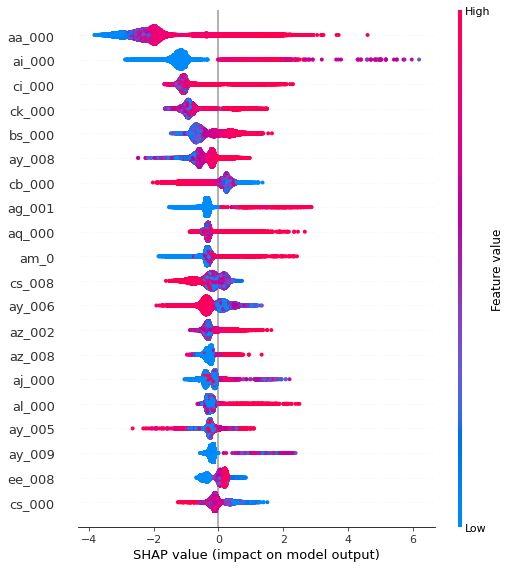

In [71]:
shap.summary_plot(shap_values[1],
                  pd.DataFrame(X,
                               columns=df_train.columns[1:]))

### SHAP value of the Top 20 Features:

We can clearly see how the SHAP value changes across different values of our features. This is good as we can now clearly see how an APS can fail.

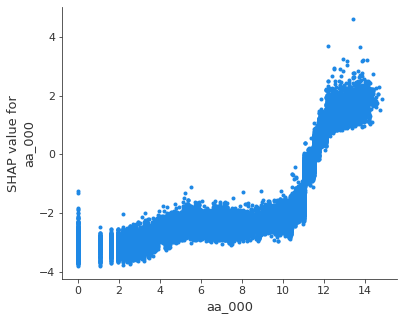

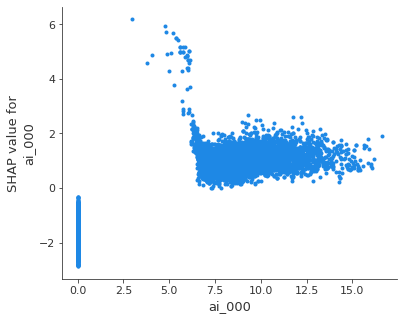

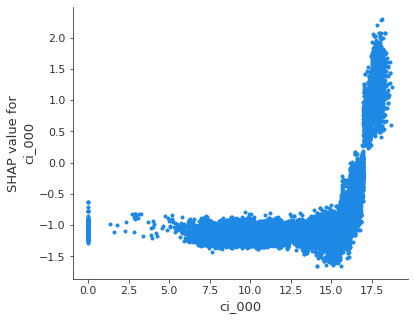

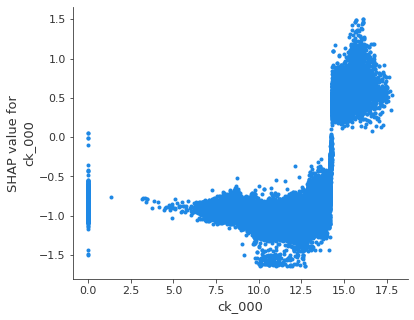

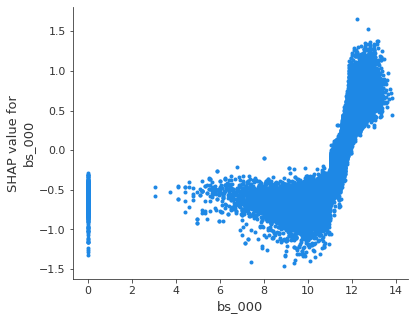

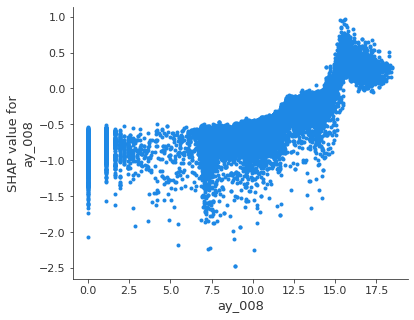

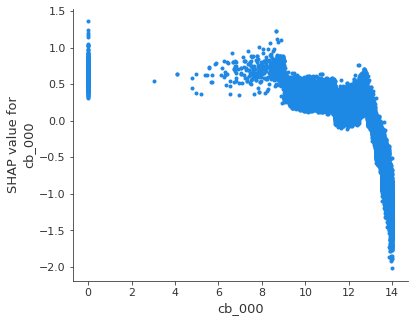

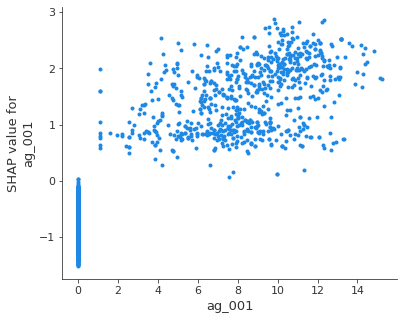

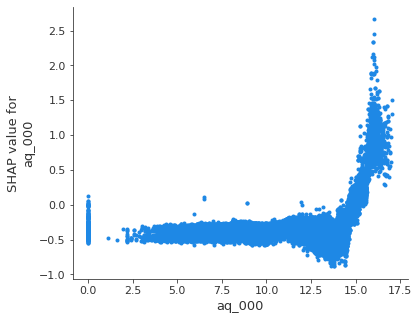

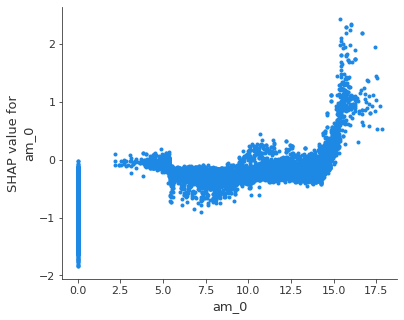

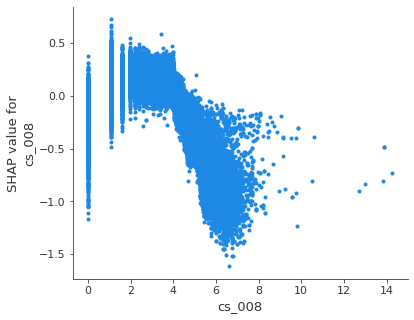

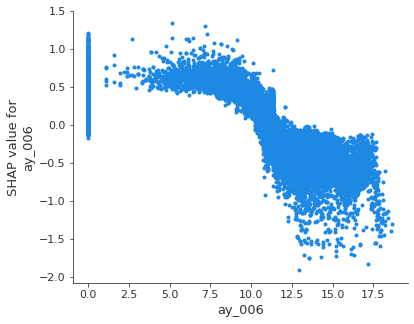

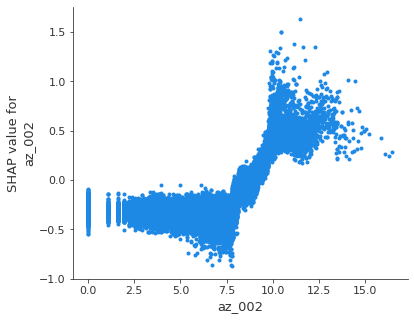

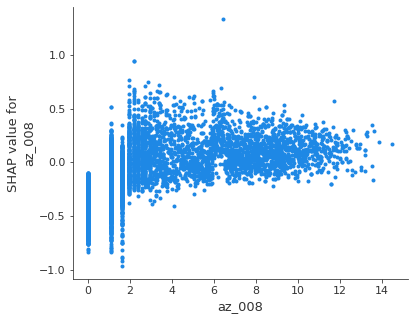

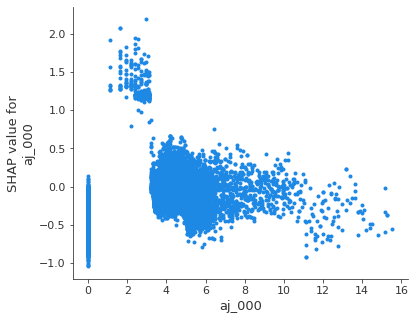

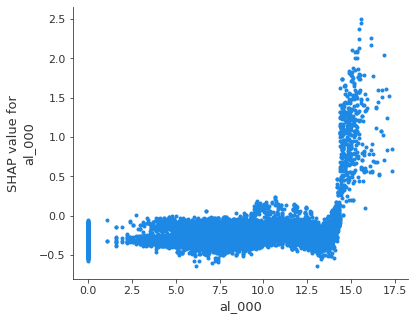

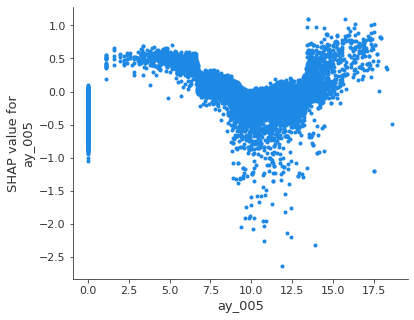

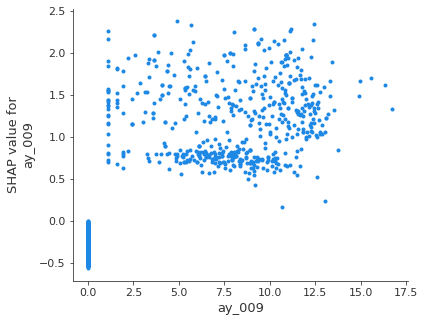

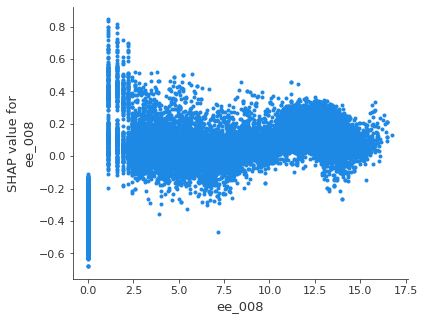

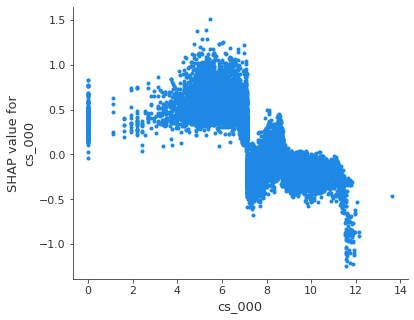

In [132]:
top_feats = ['aa_000','ai_000','ci_000','ck_000',
             'bs_000', 'ay_008','cb_000', 'ag_001',
             'aq_000', 'am_0', 'cs_008', 'ay_006',
             'az_002', 'az_008', 'aj_000', 'al_000',
             'ay_005', 'ay_009', 'ee_008', 'cs_000']
for feat in top_feats:
    shap.dependence_plot(feat, shap_values[1], pd.DataFrame(X, columns=df_train.columns[1:]), interaction_index=None)

## Re-Training Using Important Features

We will create a new model using only the important features highlighted in the previous section.

In [186]:
# use the balanced dataset
X_res3.columns=df_train.columns[1:]

np.random.seed(1)

kf_data = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_res3[top_feats], y=y_res3)

param_grid = {
    'num_leaves': [41,51],
    'min_data_in_leaf': [75, 100,125],
    'lambda_l1': [0.0001],
    'lambda_l2': [0.1,1,10]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                   objective='binary',
                                   num_boost_round=250,
                                   learning_rate=0.1,
                                   metric='auc')

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=kf_data)
lgb_model = gsearch.fit(X=X_res3[top_feats], y=y_res3)

print(lgb_model.best_params_, lgb_model.best_score_)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Nigel\anaconda3\envs\smote\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nigel\anaconda3\envs\smote\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\Nigel\anaconda3\envs\smote\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\Nigel\anaconda3\envs\smote\lib\site-packages\lightgbm\engine.py", line 264, in train
    evaluation_result_list=evaluation_result_list))
  File "C:\Users\Nigel\anaconda3\envs\smote\lib\site-packages\lightgbm\callback.py", line 221, in _callback
    _init(env)
  F

KeyboardInterrupt: 

### Training Set Validation: With Inliers - Without Synthetic Data

Reducing the number of features made the model lighter, but more than that, it seems to have improve the model's performance! **We still have to do a statistical test to confirm this**.

In [140]:
y_pred = lgb_model.best_estimator_.predict(pd.DataFrame(X, columns=df_train.columns[1:])[top_feats])
print(f1_score(y_true=y,y_pred=y_pred))
confusion_matrix(y_true=y,y_pred=y_pred)

0.9930139720558883


array([[58315,    14],
       [    0,   995]], dtype=int64)

In [142]:
import pickle as pkl
with open('lgbm.pkl', 'wb') as f:
    pkl.dump(lgb_model.best_estimator_, f)

## Test Set

Let's test if the system can still perform well even without the outlier detection model.

In [200]:
# y_pred = lgb_model.best_estimator_.predict(X_test)
# print(f1_score(y_true=Y_test,y_pred=y_pred))
# confusion_matrix(y_true=Y_test,y_pred=y_pred)

It seems that the LGBM model is overfitting due to very low score of the test set.

## Re-training with Early Stopping Rounds and Bagging and Feature Fraction

In [202]:
np.random.seed(1)

kf_data = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_res3, y=y_res3)

param_grid = {
    'num_leaves': [31,41,51],
    'min_data_in_leaf': [75, 100,125],
    'lambda_l1': [0.0001,0.001, 0.01],
    'lambda_l2': [0.1,1,10]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                   objective='binary',
                                   early_stopping_rounds=5,
                                   verbose=1,
                                   bagging_fraction=0.75,
                                   feature_fraction=0.75,
                                   num_boost_round=250,
                                   learning_rate=0.1,
                                   metric='auc')

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=kf_data)
lgb_model = gsearch.fit(X=X_res3, y=y_res3, eval_set = (X_test, Y_test))

print(lgb_model.best_params_, lgb_model.best_score_)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.978287
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.981217
[3]	valid_0's auc: 0.982276
[4]	valid_0's auc: 0.982748
[5]	valid_0's auc: 0.986478
[6]	valid_0's auc: 0.986881
[7]	valid_0's auc: 0.987213
[8]	valid_0's auc: 0.987109
[9]	valid_0's auc: 0.986387
[10]	valid_0's auc: 0.986306
[11]	valid_0's auc: 0.986474
[12]	valid_0's auc: 0.986336
Early stopping, best iteration is:
[7]	valid_0's auc: 0.987213
[1]	valid_0's auc: 0.980285
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983812
[3]	valid_0's auc: 0.983876
[4]	valid_0's auc: 0.984401
[5]	valid_0's auc: 0.986759
[6]	valid_0's auc: 0.987103
[7]	valid_0's auc: 0.987283
[8]	valid_0's auc: 0.987348
[9]	valid_0's auc: 0.986581
[10]	valid_0's auc: 0.986562
[11]	valid_0's auc: 0.986968
[12]	valid_0's auc: 0.990209
[13]	valid_0's auc: 0.990273
[14]	valid_0's auc: 0.990492
[15]	valid_0's auc: 0.990601
[16]	valid_0's auc: 0.990557
[17]	valid_0's auc: 0.9

[10]	valid_0's auc: 0.989925
[11]	valid_0's auc: 0.989921
[12]	valid_0's auc: 0.989023
[13]	valid_0's auc: 0.989377
[14]	valid_0's auc: 0.989478
[15]	valid_0's auc: 0.989518
Early stopping, best iteration is:
[10]	valid_0's auc: 0.989925
[1]	valid_0's auc: 0.981085
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984378
[3]	valid_0's auc: 0.985299
[4]	valid_0's auc: 0.985297
[5]	valid_0's auc: 0.986761
[6]	valid_0's auc: 0.988641
[7]	valid_0's auc: 0.988572
[8]	valid_0's auc: 0.986823
[9]	valid_0's auc: 0.989365
[10]	valid_0's auc: 0.989842
[11]	valid_0's auc: 0.99027
[12]	valid_0's auc: 0.988731
[13]	valid_0's auc: 0.990742
[14]	valid_0's auc: 0.990979
[15]	valid_0's auc: 0.990685
[16]	valid_0's auc: 0.989198
[17]	valid_0's auc: 0.989272
[18]	valid_0's auc: 0.989209
[19]	valid_0's auc: 0.989191
Early stopping, best iteration is:
[14]	valid_0's auc: 0.990979
[1]	valid_0's auc: 0.982266
Training until validation scores don't improve for 5 rounds
[2]	valid

[18]	valid_0's auc: 0.991403
[19]	valid_0's auc: 0.991695
[20]	valid_0's auc: 0.99181
[21]	valid_0's auc: 0.991789
[22]	valid_0's auc: 0.992112
[23]	valid_0's auc: 0.992138
[24]	valid_0's auc: 0.992094
[25]	valid_0's auc: 0.991669
[26]	valid_0's auc: 0.991669
[27]	valid_0's auc: 0.991642
[28]	valid_0's auc: 0.991696
Early stopping, best iteration is:
[23]	valid_0's auc: 0.992138
[1]	valid_0's auc: 0.982583
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983654
[3]	valid_0's auc: 0.984978
[4]	valid_0's auc: 0.985307
[5]	valid_0's auc: 0.986773
[6]	valid_0's auc: 0.987154
[7]	valid_0's auc: 0.987344
[8]	valid_0's auc: 0.987637
[9]	valid_0's auc: 0.988794
[10]	valid_0's auc: 0.989127
[11]	valid_0's auc: 0.989377
[12]	valid_0's auc: 0.991077
[13]	valid_0's auc: 0.991042
[14]	valid_0's auc: 0.991378
[15]	valid_0's auc: 0.991382
[16]	valid_0's auc: 0.991348
[17]	valid_0's auc: 0.991986
[18]	valid_0's auc: 0.991849
[19]	valid_0's auc: 0.991753
[20]	valid_0's a

[1]	valid_0's auc: 0.982451
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.981709
[3]	valid_0's auc: 0.983887
[4]	valid_0's auc: 0.986647
[5]	valid_0's auc: 0.98762
[6]	valid_0's auc: 0.987906
[7]	valid_0's auc: 0.9881
[8]	valid_0's auc: 0.987873
[9]	valid_0's auc: 0.98774
[10]	valid_0's auc: 0.987657
[11]	valid_0's auc: 0.987652
[12]	valid_0's auc: 0.987897
Early stopping, best iteration is:
[7]	valid_0's auc: 0.9881
[1]	valid_0's auc: 0.980682
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98394
[3]	valid_0's auc: 0.985146
[4]	valid_0's auc: 0.987066
[5]	valid_0's auc: 0.987814
[6]	valid_0's auc: 0.987995
[7]	valid_0's auc: 0.988357
[8]	valid_0's auc: 0.988448
[9]	valid_0's auc: 0.988339
[10]	valid_0's auc: 0.988489
[11]	valid_0's auc: 0.988382
[12]	valid_0's auc: 0.988662
[13]	valid_0's auc: 0.988589
[14]	valid_0's auc: 0.988849
[15]	valid_0's auc: 0.988911
[16]	valid_0's auc: 0.988826
[17]	valid_0's auc: 0.98915
[1

[9]	valid_0's auc: 0.989274
[10]	valid_0's auc: 0.990996
[11]	valid_0's auc: 0.991055
[12]	valid_0's auc: 0.990978
[13]	valid_0's auc: 0.991147
[14]	valid_0's auc: 0.991254
[15]	valid_0's auc: 0.991386
[16]	valid_0's auc: 0.991287
[17]	valid_0's auc: 0.991248
[18]	valid_0's auc: 0.991212
[19]	valid_0's auc: 0.991305
[20]	valid_0's auc: 0.991317
Early stopping, best iteration is:
[15]	valid_0's auc: 0.991386
[1]	valid_0's auc: 0.979516
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.981129
[3]	valid_0's auc: 0.984049
[4]	valid_0's auc: 0.985047
[5]	valid_0's auc: 0.98625
[6]	valid_0's auc: 0.987151
[7]	valid_0's auc: 0.987553
[8]	valid_0's auc: 0.987546
[9]	valid_0's auc: 0.987837
[10]	valid_0's auc: 0.989232
[11]	valid_0's auc: 0.989184
[12]	valid_0's auc: 0.990221
[13]	valid_0's auc: 0.990398
[14]	valid_0's auc: 0.990506
[15]	valid_0's auc: 0.990862
[16]	valid_0's auc: 0.990655
[17]	valid_0's auc: 0.990626
[18]	valid_0's auc: 0.990817
[19]	valid_0's au

[8]	valid_0's auc: 0.989793
[9]	valid_0's auc: 0.989027
[10]	valid_0's auc: 0.989021
[11]	valid_0's auc: 0.989026
[12]	valid_0's auc: 0.989465
[13]	valid_0's auc: 0.989477
Early stopping, best iteration is:
[8]	valid_0's auc: 0.989793
[1]	valid_0's auc: 0.978775
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983546
[3]	valid_0's auc: 0.984554
[4]	valid_0's auc: 0.985236
[5]	valid_0's auc: 0.98658
[6]	valid_0's auc: 0.987131
[7]	valid_0's auc: 0.987474
[8]	valid_0's auc: 0.987477
[9]	valid_0's auc: 0.987496
[10]	valid_0's auc: 0.987977
[11]	valid_0's auc: 0.988198
[12]	valid_0's auc: 0.989312
[13]	valid_0's auc: 0.98928
[14]	valid_0's auc: 0.989483
[15]	valid_0's auc: 0.989493
[16]	valid_0's auc: 0.98957
[17]	valid_0's auc: 0.989688
[18]	valid_0's auc: 0.989626
[19]	valid_0's auc: 0.989604
[20]	valid_0's auc: 0.989756
[21]	valid_0's auc: 0.991023
[22]	valid_0's auc: 0.990954
[23]	valid_0's auc: 0.991232
[24]	valid_0's auc: 0.991261
[25]	valid_0's auc: 0

[23]	valid_0's auc: 0.991461
[24]	valid_0's auc: 0.991456
[25]	valid_0's auc: 0.991326
[26]	valid_0's auc: 0.991311
[27]	valid_0's auc: 0.991298
[28]	valid_0's auc: 0.991164
Early stopping, best iteration is:
[23]	valid_0's auc: 0.991461
[1]	valid_0's auc: 0.980687
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983283
[3]	valid_0's auc: 0.984481
[4]	valid_0's auc: 0.984288
[5]	valid_0's auc: 0.985739
[6]	valid_0's auc: 0.988598
[7]	valid_0's auc: 0.988909
[8]	valid_0's auc: 0.989066
[9]	valid_0's auc: 0.989371
[10]	valid_0's auc: 0.990838
[11]	valid_0's auc: 0.990863
[12]	valid_0's auc: 0.991653
[13]	valid_0's auc: 0.992083
[14]	valid_0's auc: 0.992136
[15]	valid_0's auc: 0.99207
[16]	valid_0's auc: 0.99197
[17]	valid_0's auc: 0.992245
[18]	valid_0's auc: 0.992388
[19]	valid_0's auc: 0.992382
[20]	valid_0's auc: 0.992347
[21]	valid_0's auc: 0.99246
[22]	valid_0's auc: 0.992477
[23]	valid_0's auc: 0.992518
[24]	valid_0's auc: 0.992576
[25]	valid_0's auc

[11]	valid_0's auc: 0.989093
[12]	valid_0's auc: 0.989286
[13]	valid_0's auc: 0.989387
[14]	valid_0's auc: 0.989579
[15]	valid_0's auc: 0.99133
[16]	valid_0's auc: 0.991536
[17]	valid_0's auc: 0.991531
[18]	valid_0's auc: 0.991297
[19]	valid_0's auc: 0.991321
[20]	valid_0's auc: 0.991319
[21]	valid_0's auc: 0.991321
Early stopping, best iteration is:
[16]	valid_0's auc: 0.991536
[1]	valid_0's auc: 0.981406
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984413
[3]	valid_0's auc: 0.98553
[4]	valid_0's auc: 0.987806
[5]	valid_0's auc: 0.988729
[6]	valid_0's auc: 0.988629
[7]	valid_0's auc: 0.988515
[8]	valid_0's auc: 0.988949
[9]	valid_0's auc: 0.989235
[10]	valid_0's auc: 0.989591
[11]	valid_0's auc: 0.989556
[12]	valid_0's auc: 0.989481
[13]	valid_0's auc: 0.989548
[14]	valid_0's auc: 0.98973
[15]	valid_0's auc: 0.989857
[16]	valid_0's auc: 0.989926
[17]	valid_0's auc: 0.989933
[18]	valid_0's auc: 0.989698
[19]	valid_0's auc: 0.989745
[20]	valid_0's auc

[8]	valid_0's auc: 0.990085
[9]	valid_0's auc: 0.990111
[10]	valid_0's auc: 0.990239
[11]	valid_0's auc: 0.99016
[12]	valid_0's auc: 0.990392
[13]	valid_0's auc: 0.990573
[14]	valid_0's auc: 0.990725
[15]	valid_0's auc: 0.990764
[16]	valid_0's auc: 0.991019
[17]	valid_0's auc: 0.99102
[18]	valid_0's auc: 0.991038
[19]	valid_0's auc: 0.991123
[20]	valid_0's auc: 0.991252
[21]	valid_0's auc: 0.99154
[22]	valid_0's auc: 0.991543
[23]	valid_0's auc: 0.991571
[24]	valid_0's auc: 0.991645
[25]	valid_0's auc: 0.991608
[26]	valid_0's auc: 0.991554
[27]	valid_0's auc: 0.99156
[28]	valid_0's auc: 0.991585
[29]	valid_0's auc: 0.991506
Early stopping, best iteration is:
[24]	valid_0's auc: 0.991645
[1]	valid_0's auc: 0.982797
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985177
[3]	valid_0's auc: 0.985333
[4]	valid_0's auc: 0.988792
[5]	valid_0's auc: 0.987727
[6]	valid_0's auc: 0.989849
[7]	valid_0's auc: 0.989921
[8]	valid_0's auc: 0.98999
[9]	valid_0's auc: 0.

[31]	valid_0's auc: 0.991946
[32]	valid_0's auc: 0.991644
[33]	valid_0's auc: 0.991695
[34]	valid_0's auc: 0.991751
[35]	valid_0's auc: 0.991876
[36]	valid_0's auc: 0.991614
Early stopping, best iteration is:
[31]	valid_0's auc: 0.991946
[1]	valid_0's auc: 0.98062
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980728
[3]	valid_0's auc: 0.98172
[4]	valid_0's auc: 0.983008
[5]	valid_0's auc: 0.988889
[6]	valid_0's auc: 0.989606
[7]	valid_0's auc: 0.989865
[8]	valid_0's auc: 0.989994
[9]	valid_0's auc: 0.991384
[10]	valid_0's auc: 0.991334
[11]	valid_0's auc: 0.991511
[12]	valid_0's auc: 0.991539
[13]	valid_0's auc: 0.991758
[14]	valid_0's auc: 0.991895
[15]	valid_0's auc: 0.991902
[16]	valid_0's auc: 0.991853
[17]	valid_0's auc: 0.991991
[18]	valid_0's auc: 0.992046
[19]	valid_0's auc: 0.992039
[20]	valid_0's auc: 0.992101
[21]	valid_0's auc: 0.99227
[22]	valid_0's auc: 0.992481
[23]	valid_0's auc: 0.992506
[24]	valid_0's auc: 0.992525
[25]	valid_0's auc

[21]	valid_0's auc: 0.990643
[22]	valid_0's auc: 0.990673
[23]	valid_0's auc: 0.990817
[24]	valid_0's auc: 0.99079
[25]	valid_0's auc: 0.990931
[26]	valid_0's auc: 0.991078
[27]	valid_0's auc: 0.991121
[28]	valid_0's auc: 0.991015
[29]	valid_0's auc: 0.991027
[30]	valid_0's auc: 0.991213
[31]	valid_0's auc: 0.990918
[32]	valid_0's auc: 0.99104
[33]	valid_0's auc: 0.991033
[34]	valid_0's auc: 0.991918
[35]	valid_0's auc: 0.992034
[36]	valid_0's auc: 0.991844
[37]	valid_0's auc: 0.991738
[38]	valid_0's auc: 0.991602
[39]	valid_0's auc: 0.991413
[40]	valid_0's auc: 0.991377
Early stopping, best iteration is:
[35]	valid_0's auc: 0.992034
[1]	valid_0's auc: 0.980119
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982231
[3]	valid_0's auc: 0.984545
[4]	valid_0's auc: 0.985584
[5]	valid_0's auc: 0.988989
[6]	valid_0's auc: 0.989739
[7]	valid_0's auc: 0.989766
[8]	valid_0's auc: 0.989551
[9]	valid_0's auc: 0.990849
[10]	valid_0's auc: 0.991202
[11]	valid_0's au

[20]	valid_0's auc: 0.990886
[21]	valid_0's auc: 0.991142
[22]	valid_0's auc: 0.991049
[23]	valid_0's auc: 0.991057
[24]	valid_0's auc: 0.991096
[25]	valid_0's auc: 0.99096
[26]	valid_0's auc: 0.990952
Early stopping, best iteration is:
[21]	valid_0's auc: 0.991142
[1]	valid_0's auc: 0.980238
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982677
[3]	valid_0's auc: 0.984114
[4]	valid_0's auc: 0.985039
[5]	valid_0's auc: 0.987016
[6]	valid_0's auc: 0.987558
[7]	valid_0's auc: 0.987877
[8]	valid_0's auc: 0.988064
[9]	valid_0's auc: 0.989222
[10]	valid_0's auc: 0.991118
[11]	valid_0's auc: 0.991063
[12]	valid_0's auc: 0.990884
[13]	valid_0's auc: 0.991064
[14]	valid_0's auc: 0.991484
[15]	valid_0's auc: 0.991527
[16]	valid_0's auc: 0.991589
[17]	valid_0's auc: 0.991642
[18]	valid_0's auc: 0.991396
[19]	valid_0's auc: 0.991363
[20]	valid_0's auc: 0.991453
[21]	valid_0's auc: 0.991521
[22]	valid_0's auc: 0.991603
Early stopping, best iteration is:
[17]	valid

[20]	valid_0's auc: 0.992462
[21]	valid_0's auc: 0.992645
[22]	valid_0's auc: 0.992774
[23]	valid_0's auc: 0.992815
[24]	valid_0's auc: 0.9928
[25]	valid_0's auc: 0.992785
[26]	valid_0's auc: 0.992768
[27]	valid_0's auc: 0.992856
[28]	valid_0's auc: 0.992788
[29]	valid_0's auc: 0.992843
[30]	valid_0's auc: 0.992808
[31]	valid_0's auc: 0.992853
[32]	valid_0's auc: 0.992872
[33]	valid_0's auc: 0.992854
[34]	valid_0's auc: 0.992869
[35]	valid_0's auc: 0.992852
[36]	valid_0's auc: 0.992792
[37]	valid_0's auc: 0.992777
Early stopping, best iteration is:
[32]	valid_0's auc: 0.992872
[1]	valid_0's auc: 0.981744
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98241
[3]	valid_0's auc: 0.984232
[4]	valid_0's auc: 0.986936
[5]	valid_0's auc: 0.987735
[6]	valid_0's auc: 0.987775
[7]	valid_0's auc: 0.98798
[8]	valid_0's auc: 0.988239
[9]	valid_0's auc: 0.988211
[10]	valid_0's auc: 0.988278
[11]	valid_0's auc: 0.98828
[12]	valid_0's auc: 0.988289
[13]	valid_0's auc: 

[11]	valid_0's auc: 0.989241
[12]	valid_0's auc: 0.989335
[13]	valid_0's auc: 0.989619
[14]	valid_0's auc: 0.989896
[15]	valid_0's auc: 0.990005
[16]	valid_0's auc: 0.990134
[17]	valid_0's auc: 0.990481
[18]	valid_0's auc: 0.990563
[19]	valid_0's auc: 0.990689
[20]	valid_0's auc: 0.990944
[21]	valid_0's auc: 0.99106
[22]	valid_0's auc: 0.990765
[23]	valid_0's auc: 0.990923
[24]	valid_0's auc: 0.990973
[25]	valid_0's auc: 0.990864
[26]	valid_0's auc: 0.990814
Early stopping, best iteration is:
[21]	valid_0's auc: 0.99106
[1]	valid_0's auc: 0.982112
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983605
[3]	valid_0's auc: 0.983886
[4]	valid_0's auc: 0.987124
[5]	valid_0's auc: 0.988324
[6]	valid_0's auc: 0.988381
[7]	valid_0's auc: 0.988636
[8]	valid_0's auc: 0.989777
[9]	valid_0's auc: 0.989919
[10]	valid_0's auc: 0.990275
[11]	valid_0's auc: 0.990309
[12]	valid_0's auc: 0.990112
[13]	valid_0's auc: 0.990116
[14]	valid_0's auc: 0.990563
[15]	valid_0's au

[19]	valid_0's auc: 0.989849
[20]	valid_0's auc: 0.991198
[21]	valid_0's auc: 0.99099
[22]	valid_0's auc: 0.991121
[23]	valid_0's auc: 0.990975
[24]	valid_0's auc: 0.991158
[25]	valid_0's auc: 0.991094
Early stopping, best iteration is:
[20]	valid_0's auc: 0.991198
[1]	valid_0's auc: 0.981398
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983198
[3]	valid_0's auc: 0.984737
[4]	valid_0's auc: 0.98446
[5]	valid_0's auc: 0.985715
[6]	valid_0's auc: 0.985588
[7]	valid_0's auc: 0.986338
[8]	valid_0's auc: 0.986724
[9]	valid_0's auc: 0.986211
[10]	valid_0's auc: 0.986525
[11]	valid_0's auc: 0.986596
[12]	valid_0's auc: 0.98996
[13]	valid_0's auc: 0.990063
[14]	valid_0's auc: 0.990396
[15]	valid_0's auc: 0.99043
[16]	valid_0's auc: 0.99032
[17]	valid_0's auc: 0.990419
[18]	valid_0's auc: 0.990512
[19]	valid_0's auc: 0.990735
[20]	valid_0's auc: 0.99093
[21]	valid_0's auc: 0.991108
[22]	valid_0's auc: 0.991102
[23]	valid_0's auc: 0.99124
[24]	valid_0's auc: 0.

[7]	valid_0's auc: 0.988667
[8]	valid_0's auc: 0.988641
[9]	valid_0's auc: 0.990032
[10]	valid_0's auc: 0.988371
[11]	valid_0's auc: 0.988442
[12]	valid_0's auc: 0.988367
[13]	valid_0's auc: 0.988439
[14]	valid_0's auc: 0.988603
Early stopping, best iteration is:
[9]	valid_0's auc: 0.990032
[1]	valid_0's auc: 0.977179
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980356
[3]	valid_0's auc: 0.984042
[4]	valid_0's auc: 0.985749
[5]	valid_0's auc: 0.986868
[6]	valid_0's auc: 0.987681
[7]	valid_0's auc: 0.988164
[8]	valid_0's auc: 0.988622
[9]	valid_0's auc: 0.989893
[10]	valid_0's auc: 0.990104
[11]	valid_0's auc: 0.990277
[12]	valid_0's auc: 0.988239
[13]	valid_0's auc: 0.986505
[14]	valid_0's auc: 0.986539
[15]	valid_0's auc: 0.988799
[16]	valid_0's auc: 0.988834
Early stopping, best iteration is:
[11]	valid_0's auc: 0.990277
[1]	valid_0's auc: 0.982756
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.981306
[3]	valid_0's

[9]	valid_0's auc: 0.988579
[10]	valid_0's auc: 0.987255
[11]	valid_0's auc: 0.98748
[12]	valid_0's auc: 0.990463
[13]	valid_0's auc: 0.99039
[14]	valid_0's auc: 0.99057
[15]	valid_0's auc: 0.990656
[16]	valid_0's auc: 0.990649
[17]	valid_0's auc: 0.990558
[18]	valid_0's auc: 0.990601
[19]	valid_0's auc: 0.990737
[20]	valid_0's auc: 0.99092
[21]	valid_0's auc: 0.991114
[22]	valid_0's auc: 0.991441
[23]	valid_0's auc: 0.991457
[24]	valid_0's auc: 0.991463
[25]	valid_0's auc: 0.991479
[26]	valid_0's auc: 0.991457
[27]	valid_0's auc: 0.991429
[28]	valid_0's auc: 0.991388
[29]	valid_0's auc: 0.991404
[30]	valid_0's auc: 0.991472
Early stopping, best iteration is:
[25]	valid_0's auc: 0.991479
[1]	valid_0's auc: 0.979898
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982913
[3]	valid_0's auc: 0.984262
[4]	valid_0's auc: 0.98489
[5]	valid_0's auc: 0.985891
[6]	valid_0's auc: 0.986587
[7]	valid_0's auc: 0.985124
[8]	valid_0's auc: 0.984943
[9]	valid_0's auc: 0

[16]	valid_0's auc: 0.989098
[17]	valid_0's auc: 0.989051
[18]	valid_0's auc: 0.989228
[19]	valid_0's auc: 0.990393
[20]	valid_0's auc: 0.990501
[21]	valid_0's auc: 0.990569
[22]	valid_0's auc: 0.991049
[23]	valid_0's auc: 0.991202
[24]	valid_0's auc: 0.99117
[25]	valid_0's auc: 0.991211
[26]	valid_0's auc: 0.991191
[27]	valid_0's auc: 0.991677
[28]	valid_0's auc: 0.991707
[29]	valid_0's auc: 0.991603
[30]	valid_0's auc: 0.991734
[31]	valid_0's auc: 0.991782
[32]	valid_0's auc: 0.992012
[33]	valid_0's auc: 0.991887
[34]	valid_0's auc: 0.991956
[35]	valid_0's auc: 0.991906
[36]	valid_0's auc: 0.991891
[37]	valid_0's auc: 0.991864
Early stopping, best iteration is:
[32]	valid_0's auc: 0.992012
[1]	valid_0's auc: 0.982206
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984295
[3]	valid_0's auc: 0.984678
[4]	valid_0's auc: 0.987417
[5]	valid_0's auc: 0.987545
[6]	valid_0's auc: 0.987776
[7]	valid_0's auc: 0.987789
[8]	valid_0's auc: 0.988123
[9]	valid_0's a

[7]	valid_0's auc: 0.990045
[8]	valid_0's auc: 0.988654
[9]	valid_0's auc: 0.988573
[10]	valid_0's auc: 0.988713
[11]	valid_0's auc: 0.988795
Early stopping, best iteration is:
[6]	valid_0's auc: 0.99025
[1]	valid_0's auc: 0.980755
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982874
[3]	valid_0's auc: 0.982999
[4]	valid_0's auc: 0.985995
[5]	valid_0's auc: 0.985691
[6]	valid_0's auc: 0.985532
[7]	valid_0's auc: 0.985698
[8]	valid_0's auc: 0.987677
[9]	valid_0's auc: 0.987823
[10]	valid_0's auc: 0.990088
[11]	valid_0's auc: 0.990299
[12]	valid_0's auc: 0.990285
[13]	valid_0's auc: 0.990397
[14]	valid_0's auc: 0.990448
[15]	valid_0's auc: 0.990541
[16]	valid_0's auc: 0.99065
[17]	valid_0's auc: 0.991086
[18]	valid_0's auc: 0.991171
[19]	valid_0's auc: 0.99121
[20]	valid_0's auc: 0.991282
[21]	valid_0's auc: 0.991356
[22]	valid_0's auc: 0.991655
[23]	valid_0's auc: 0.99168
[24]	valid_0's auc: 0.991755
[25]	valid_0's auc: 0.991551
[26]	valid_0's auc: 0.9

[9]	valid_0's auc: 0.989547
[10]	valid_0's auc: 0.989588
[11]	valid_0's auc: 0.989794
[12]	valid_0's auc: 0.988378
[13]	valid_0's auc: 0.988638
[14]	valid_0's auc: 0.988814
[15]	valid_0's auc: 0.988896
[16]	valid_0's auc: 0.988976
Early stopping, best iteration is:
[11]	valid_0's auc: 0.989794
[1]	valid_0's auc: 0.983823
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983911
[3]	valid_0's auc: 0.984894
[4]	valid_0's auc: 0.984794
[5]	valid_0's auc: 0.985891
[6]	valid_0's auc: 0.986619
[7]	valid_0's auc: 0.987248
[8]	valid_0's auc: 0.987529
[9]	valid_0's auc: 0.988838
[10]	valid_0's auc: 0.990992
[11]	valid_0's auc: 0.990913
[12]	valid_0's auc: 0.990603
[13]	valid_0's auc: 0.99076
[14]	valid_0's auc: 0.99085
[15]	valid_0's auc: 0.990732
Early stopping, best iteration is:
[10]	valid_0's auc: 0.990992
[1]	valid_0's auc: 0.982875
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984172
[3]	valid_0's auc: 0.985403
[4]	valid_0's

[10]	valid_0's auc: 0.988764
[11]	valid_0's auc: 0.98877
[12]	valid_0's auc: 0.988931
[13]	valid_0's auc: 0.989185
[14]	valid_0's auc: 0.989577
[15]	valid_0's auc: 0.989504
[16]	valid_0's auc: 0.989548
[17]	valid_0's auc: 0.989766
[18]	valid_0's auc: 0.98968
[19]	valid_0's auc: 0.989462
[20]	valid_0's auc: 0.989274
[21]	valid_0's auc: 0.990577
[22]	valid_0's auc: 0.990717
[23]	valid_0's auc: 0.990799
[24]	valid_0's auc: 0.990856
[25]	valid_0's auc: 0.990992
[26]	valid_0's auc: 0.991177
[27]	valid_0's auc: 0.991131
[28]	valid_0's auc: 0.991183
[29]	valid_0's auc: 0.991239
[30]	valid_0's auc: 0.991357
[31]	valid_0's auc: 0.991193
[32]	valid_0's auc: 0.991271
[33]	valid_0's auc: 0.991275
[34]	valid_0's auc: 0.99123
[35]	valid_0's auc: 0.991224
Early stopping, best iteration is:
[30]	valid_0's auc: 0.991357
[1]	valid_0's auc: 0.981428
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983441
[3]	valid_0's auc: 0.984766
[4]	valid_0's auc: 0.985445
[5]	valid_0's

[15]	valid_0's auc: 0.990744
[16]	valid_0's auc: 0.990821
[17]	valid_0's auc: 0.991166
[18]	valid_0's auc: 0.991568
[19]	valid_0's auc: 0.991316
[20]	valid_0's auc: 0.991451
[21]	valid_0's auc: 0.99158
[22]	valid_0's auc: 0.991677
[23]	valid_0's auc: 0.991761
[24]	valid_0's auc: 0.991914
[25]	valid_0's auc: 0.992194
[26]	valid_0's auc: 0.992206
[27]	valid_0's auc: 0.99216
[28]	valid_0's auc: 0.992068
[29]	valid_0's auc: 0.992014
[30]	valid_0's auc: 0.991962
[31]	valid_0's auc: 0.991527
Early stopping, best iteration is:
[26]	valid_0's auc: 0.992206
[1]	valid_0's auc: 0.980869
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984061
[3]	valid_0's auc: 0.986927
[4]	valid_0's auc: 0.987231
[5]	valid_0's auc: 0.988429
[6]	valid_0's auc: 0.989102
[7]	valid_0's auc: 0.989328
[8]	valid_0's auc: 0.989384
[9]	valid_0's auc: 0.990431
[10]	valid_0's auc: 0.990545
[11]	valid_0's auc: 0.990755
[12]	valid_0's auc: 0.990947
[13]	valid_0's auc: 0.991143
[14]	valid_0's au

[1]	valid_0's auc: 0.982546
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984982
[3]	valid_0's auc: 0.984957
[4]	valid_0's auc: 0.987246
[5]	valid_0's auc: 0.987453
[6]	valid_0's auc: 0.987633
[7]	valid_0's auc: 0.987882
[8]	valid_0's auc: 0.988194
[9]	valid_0's auc: 0.988704
[10]	valid_0's auc: 0.988687
[11]	valid_0's auc: 0.988617
[12]	valid_0's auc: 0.988597
[13]	valid_0's auc: 0.988815
[14]	valid_0's auc: 0.989029
[15]	valid_0's auc: 0.988707
[16]	valid_0's auc: 0.98895
[17]	valid_0's auc: 0.989009
[18]	valid_0's auc: 0.989208
[19]	valid_0's auc: 0.989313
[20]	valid_0's auc: 0.989381
[21]	valid_0's auc: 0.989618
[22]	valid_0's auc: 0.99083
[23]	valid_0's auc: 0.990902
[24]	valid_0's auc: 0.990977
[25]	valid_0's auc: 0.990903
[26]	valid_0's auc: 0.99105
[27]	valid_0's auc: 0.991111
[28]	valid_0's auc: 0.991107
[29]	valid_0's auc: 0.991047
[30]	valid_0's auc: 0.991192
[31]	valid_0's auc: 0.991328
[32]	valid_0's auc: 0.991334
[33]	valid_0's auc: 0.99

[1]	valid_0's auc: 0.984588
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984487
[3]	valid_0's auc: 0.98517
[4]	valid_0's auc: 0.988492
[5]	valid_0's auc: 0.989361
[6]	valid_0's auc: 0.989835
[7]	valid_0's auc: 0.989938
[8]	valid_0's auc: 0.990135
[9]	valid_0's auc: 0.990019
[10]	valid_0's auc: 0.990014
[11]	valid_0's auc: 0.989963
[12]	valid_0's auc: 0.988879
[13]	valid_0's auc: 0.990718
[14]	valid_0's auc: 0.991019
[15]	valid_0's auc: 0.990331
[16]	valid_0's auc: 0.990491
[17]	valid_0's auc: 0.990688
[18]	valid_0's auc: 0.990832
[19]	valid_0's auc: 0.990886
Early stopping, best iteration is:
[14]	valid_0's auc: 0.991019
[1]	valid_0's auc: 0.98029
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983556
[3]	valid_0's auc: 0.983826
[4]	valid_0's auc: 0.986169
[5]	valid_0's auc: 0.987395
[6]	valid_0's auc: 0.985577
[7]	valid_0's auc: 0.985671
[8]	valid_0's auc: 0.987851
[9]	valid_0's auc: 0.988173
[10]	valid_0's auc: 0.98

[8]	valid_0's auc: 0.988568
[9]	valid_0's auc: 0.988832
[10]	valid_0's auc: 0.989242
[11]	valid_0's auc: 0.989208
[12]	valid_0's auc: 0.990329
[13]	valid_0's auc: 0.990688
[14]	valid_0's auc: 0.99076
[15]	valid_0's auc: 0.990861
[16]	valid_0's auc: 0.990854
[17]	valid_0's auc: 0.991008
[18]	valid_0's auc: 0.991053
[19]	valid_0's auc: 0.990992
[20]	valid_0's auc: 0.990926
[21]	valid_0's auc: 0.990879
[22]	valid_0's auc: 0.990967
[23]	valid_0's auc: 0.990951
Early stopping, best iteration is:
[18]	valid_0's auc: 0.991053
[1]	valid_0's auc: 0.980742
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983244
[3]	valid_0's auc: 0.984405
[4]	valid_0's auc: 0.984801
[5]	valid_0's auc: 0.986533
[6]	valid_0's auc: 0.988575
[7]	valid_0's auc: 0.9883
[8]	valid_0's auc: 0.988338
[9]	valid_0's auc: 0.989615
[10]	valid_0's auc: 0.989978
[11]	valid_0's auc: 0.990377
[12]	valid_0's auc: 0.990218
[13]	valid_0's auc: 0.990414
[14]	valid_0's auc: 0.990657
[15]	valid_0's auc: 

[24]	valid_0's auc: 0.991947
[25]	valid_0's auc: 0.991993
[26]	valid_0's auc: 0.992047
Early stopping, best iteration is:
[21]	valid_0's auc: 0.992125
[1]	valid_0's auc: 0.980673
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980786
[3]	valid_0's auc: 0.981784
[4]	valid_0's auc: 0.982597
[5]	valid_0's auc: 0.988431
[6]	valid_0's auc: 0.990306
[7]	valid_0's auc: 0.990171
[8]	valid_0's auc: 0.990293
[9]	valid_0's auc: 0.990419
[10]	valid_0's auc: 0.990557
[11]	valid_0's auc: 0.990459
[12]	valid_0's auc: 0.990727
[13]	valid_0's auc: 0.991223
[14]	valid_0's auc: 0.99139
[15]	valid_0's auc: 0.991435
[16]	valid_0's auc: 0.991363
[17]	valid_0's auc: 0.991573
[18]	valid_0's auc: 0.99168
[19]	valid_0's auc: 0.991781
[20]	valid_0's auc: 0.991938
[21]	valid_0's auc: 0.992137
[22]	valid_0's auc: 0.992148
[23]	valid_0's auc: 0.992063
[24]	valid_0's auc: 0.992281
[25]	valid_0's auc: 0.992353
[26]	valid_0's auc: 0.992401
[27]	valid_0's auc: 0.992416
[28]	valid_0's au

[8]	valid_0's auc: 0.987967
[9]	valid_0's auc: 0.989381
[10]	valid_0's auc: 0.989676
[11]	valid_0's auc: 0.989708
[12]	valid_0's auc: 0.989781
[13]	valid_0's auc: 0.989821
[14]	valid_0's auc: 0.989968
[15]	valid_0's auc: 0.990061
[16]	valid_0's auc: 0.990247
[17]	valid_0's auc: 0.990245
[18]	valid_0's auc: 0.990439
[19]	valid_0's auc: 0.990598
[20]	valid_0's auc: 0.990667
[21]	valid_0's auc: 0.990996
[22]	valid_0's auc: 0.991079
[23]	valid_0's auc: 0.991183
[24]	valid_0's auc: 0.991179
[25]	valid_0's auc: 0.991333
[26]	valid_0's auc: 0.991428
[27]	valid_0's auc: 0.991457
[28]	valid_0's auc: 0.991503
[29]	valid_0's auc: 0.991282
[30]	valid_0's auc: 0.991357
[31]	valid_0's auc: 0.991454
[32]	valid_0's auc: 0.991147
[33]	valid_0's auc: 0.991112
Early stopping, best iteration is:
[28]	valid_0's auc: 0.991503
[1]	valid_0's auc: 0.978354
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980481
[3]	valid_0's auc: 0.981044
[4]	valid_0's auc: 0.982515
[5]	valid_0'

[26]	valid_0's auc: 0.991903
[27]	valid_0's auc: 0.992036
[28]	valid_0's auc: 0.99199
[29]	valid_0's auc: 0.991973
Early stopping, best iteration is:
[24]	valid_0's auc: 0.992056
[1]	valid_0's auc: 0.981714
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982723
[3]	valid_0's auc: 0.984251
[4]	valid_0's auc: 0.987274
[5]	valid_0's auc: 0.989336
[6]	valid_0's auc: 0.989487
[7]	valid_0's auc: 0.989737
[8]	valid_0's auc: 0.989632
[9]	valid_0's auc: 0.989692
[10]	valid_0's auc: 0.989878
[11]	valid_0's auc: 0.989916
[12]	valid_0's auc: 0.990003
[13]	valid_0's auc: 0.990142
[14]	valid_0's auc: 0.99037
[15]	valid_0's auc: 0.991544
[16]	valid_0's auc: 0.991684
[17]	valid_0's auc: 0.991764
[18]	valid_0's auc: 0.991803
[19]	valid_0's auc: 0.991876
[20]	valid_0's auc: 0.992025
[21]	valid_0's auc: 0.992118
[22]	valid_0's auc: 0.992169
[23]	valid_0's auc: 0.992028
[24]	valid_0's auc: 0.992092
[25]	valid_0's auc: 0.992069
[26]	valid_0's auc: 0.992054
[27]	valid_0's au

[1]	valid_0's auc: 0.982477
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980431
[3]	valid_0's auc: 0.982048
[4]	valid_0's auc: 0.982853
[5]	valid_0's auc: 0.988595
[6]	valid_0's auc: 0.988855
[7]	valid_0's auc: 0.989342
[8]	valid_0's auc: 0.988952
[9]	valid_0's auc: 0.99037
[10]	valid_0's auc: 0.990763
[11]	valid_0's auc: 0.990978
[12]	valid_0's auc: 0.991277
[13]	valid_0's auc: 0.991614
[14]	valid_0's auc: 0.991619
[15]	valid_0's auc: 0.991755
[16]	valid_0's auc: 0.991835
[17]	valid_0's auc: 0.991998
[18]	valid_0's auc: 0.991957
[19]	valid_0's auc: 0.991969
[20]	valid_0's auc: 0.992022
[21]	valid_0's auc: 0.992236
[22]	valid_0's auc: 0.992313
[23]	valid_0's auc: 0.992295
[24]	valid_0's auc: 0.992384
[25]	valid_0's auc: 0.992729
[26]	valid_0's auc: 0.992703
[27]	valid_0's auc: 0.992714
[28]	valid_0's auc: 0.992933
[29]	valid_0's auc: 0.992792
[30]	valid_0's auc: 0.992781
[31]	valid_0's auc: 0.992707
[32]	valid_0's auc: 0.992588
[33]	valid_0's auc: 0.

[1]	valid_0's auc: 0.982756
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.981306
[3]	valid_0's auc: 0.982148
[4]	valid_0's auc: 0.985331
[5]	valid_0's auc: 0.988985
[6]	valid_0's auc: 0.990786
[7]	valid_0's auc: 0.990769
[8]	valid_0's auc: 0.990939
[9]	valid_0's auc: 0.990935
[10]	valid_0's auc: 0.990912
[11]	valid_0's auc: 0.991178
[12]	valid_0's auc: 0.990985
[13]	valid_0's auc: 0.991197
[14]	valid_0's auc: 0.991369
[15]	valid_0's auc: 0.99146
[16]	valid_0's auc: 0.991571
[17]	valid_0's auc: 0.991658
[18]	valid_0's auc: 0.991894
[19]	valid_0's auc: 0.992081
[20]	valid_0's auc: 0.992178
[21]	valid_0's auc: 0.992147
[22]	valid_0's auc: 0.992201
[23]	valid_0's auc: 0.992098
[24]	valid_0's auc: 0.992356
[25]	valid_0's auc: 0.992566
[26]	valid_0's auc: 0.992645
[27]	valid_0's auc: 0.992658
[28]	valid_0's auc: 0.992693
[29]	valid_0's auc: 0.992586
[30]	valid_0's auc: 0.99261
[31]	valid_0's auc: 0.992596
[32]	valid_0's auc: 0.992435
[33]	valid_0's auc: 0.9

[5]	valid_0's auc: 0.985891
[6]	valid_0's auc: 0.986587
[7]	valid_0's auc: 0.985124
[8]	valid_0's auc: 0.984943
[9]	valid_0's auc: 0.986171
[10]	valid_0's auc: 0.986748
[11]	valid_0's auc: 0.987082
[12]	valid_0's auc: 0.989009
[13]	valid_0's auc: 0.989113
[14]	valid_0's auc: 0.989155
[15]	valid_0's auc: 0.991142
[16]	valid_0's auc: 0.989336
[17]	valid_0's auc: 0.991034
[18]	valid_0's auc: 0.989628
[19]	valid_0's auc: 0.989389
[20]	valid_0's auc: 0.99123
[21]	valid_0's auc: 0.991186
[22]	valid_0's auc: 0.991199
[23]	valid_0's auc: 0.989868
[24]	valid_0's auc: 0.989896
[25]	valid_0's auc: 0.99008
Early stopping, best iteration is:
[20]	valid_0's auc: 0.99123
[1]	valid_0's auc: 0.978861
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982754
[3]	valid_0's auc: 0.985711
[4]	valid_0's auc: 0.986657
[5]	valid_0's auc: 0.987545
[6]	valid_0's auc: 0.988369
[7]	valid_0's auc: 0.988704
[8]	valid_0's auc: 0.988782
[9]	valid_0's auc: 0.988909
[10]	valid_0's auc: 0.9

[26]	valid_0's auc: 0.991076
[27]	valid_0's auc: 0.991158
[28]	valid_0's auc: 0.991209
[29]	valid_0's auc: 0.991091
Early stopping, best iteration is:
[24]	valid_0's auc: 0.991254
[1]	valid_0's auc: 0.980868
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984354
[3]	valid_0's auc: 0.984746
[4]	valid_0's auc: 0.986847
[5]	valid_0's auc: 0.987291
[6]	valid_0's auc: 0.987203
[7]	valid_0's auc: 0.98741
[8]	valid_0's auc: 0.987775
[9]	valid_0's auc: 0.987799
[10]	valid_0's auc: 0.988028
[11]	valid_0's auc: 0.988033
[12]	valid_0's auc: 0.987905
[13]	valid_0's auc: 0.988035
[14]	valid_0's auc: 0.988273
[15]	valid_0's auc: 0.989752
[16]	valid_0's auc: 0.98984
[17]	valid_0's auc: 0.99
[18]	valid_0's auc: 0.990179
[19]	valid_0's auc: 0.990202
[20]	valid_0's auc: 0.990202
[21]	valid_0's auc: 0.990607
[22]	valid_0's auc: 0.991366
[23]	valid_0's auc: 0.991328
[24]	valid_0's auc: 0.991427
[25]	valid_0's auc: 0.991381
[26]	valid_0's auc: 0.991582
[27]	valid_0's auc: 0

[26]	valid_0's auc: 0.991577
[27]	valid_0's auc: 0.991604
[28]	valid_0's auc: 0.991573
[29]	valid_0's auc: 0.991512
Early stopping, best iteration is:
[24]	valid_0's auc: 0.991738
[1]	valid_0's auc: 0.975643
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983041
[3]	valid_0's auc: 0.985495
[4]	valid_0's auc: 0.988541
[5]	valid_0's auc: 0.988796
[6]	valid_0's auc: 0.987115
[7]	valid_0's auc: 0.987475
[8]	valid_0's auc: 0.989228
[9]	valid_0's auc: 0.989478
[10]	valid_0's auc: 0.989526
[11]	valid_0's auc: 0.989856
[12]	valid_0's auc: 0.990137
[13]	valid_0's auc: 0.990342
[14]	valid_0's auc: 0.990556
[15]	valid_0's auc: 0.98995
[16]	valid_0's auc: 0.990132
[17]	valid_0's auc: 0.990302
[18]	valid_0's auc: 0.990238
[19]	valid_0's auc: 0.990202
Early stopping, best iteration is:
[14]	valid_0's auc: 0.990556
[1]	valid_0's auc: 0.979214
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982568
[3]	valid_0's auc: 0.982865
[4]	valid_0

[1]	valid_0's auc: 0.981428
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983441
[3]	valid_0's auc: 0.984766
[4]	valid_0's auc: 0.985445
[5]	valid_0's auc: 0.986675
[6]	valid_0's auc: 0.988677
[7]	valid_0's auc: 0.988901
[8]	valid_0's auc: 0.98898
[9]	valid_0's auc: 0.989161
[10]	valid_0's auc: 0.989166
[11]	valid_0's auc: 0.989204
[12]	valid_0's auc: 0.989195
[13]	valid_0's auc: 0.989245
[14]	valid_0's auc: 0.989539
[15]	valid_0's auc: 0.98958
[16]	valid_0's auc: 0.989508
[17]	valid_0's auc: 0.989559
[18]	valid_0's auc: 0.989727
[19]	valid_0's auc: 0.989962
[20]	valid_0's auc: 0.989878
[21]	valid_0's auc: 0.989694
[22]	valid_0's auc: 0.989933
[23]	valid_0's auc: 0.989956
[24]	valid_0's auc: 0.991215
[25]	valid_0's auc: 0.991379
[26]	valid_0's auc: 0.99146
[27]	valid_0's auc: 0.991567
[28]	valid_0's auc: 0.991653
[29]	valid_0's auc: 0.991626
[30]	valid_0's auc: 0.991786
[31]	valid_0's auc: 0.991945
[32]	valid_0's auc: 0.991462
[33]	valid_0's auc: 0.99

[1]	valid_0's auc: 0.980869
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98406
[3]	valid_0's auc: 0.986927
[4]	valid_0's auc: 0.987219
[5]	valid_0's auc: 0.98843
[6]	valid_0's auc: 0.989106
[7]	valid_0's auc: 0.989332
[8]	valid_0's auc: 0.989381
[9]	valid_0's auc: 0.990433
[10]	valid_0's auc: 0.990546
[11]	valid_0's auc: 0.990757
[12]	valid_0's auc: 0.990947
[13]	valid_0's auc: 0.991145
[14]	valid_0's auc: 0.991252
[15]	valid_0's auc: 0.991317
[16]	valid_0's auc: 0.991223
[17]	valid_0's auc: 0.991958
[18]	valid_0's auc: 0.992256
[19]	valid_0's auc: 0.992081
[20]	valid_0's auc: 0.991631
[21]	valid_0's auc: 0.991701
[22]	valid_0's auc: 0.991709
[23]	valid_0's auc: 0.991706
Early stopping, best iteration is:
[18]	valid_0's auc: 0.992256
[1]	valid_0's auc: 0.982221
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983383
[3]	valid_0's auc: 0.985523
[4]	valid_0's auc: 0.98628
[5]	valid_0's auc: 0.987307
[6]	valid_0's auc: 0.

[30]	valid_0's auc: 0.991191
[31]	valid_0's auc: 0.991327
[32]	valid_0's auc: 0.991333
[33]	valid_0's auc: 0.991698
[34]	valid_0's auc: 0.991452
[35]	valid_0's auc: 0.99221
[36]	valid_0's auc: 0.992265
[37]	valid_0's auc: 0.992144
[38]	valid_0's auc: 0.992094
[39]	valid_0's auc: 0.991947
[40]	valid_0's auc: 0.991838
[41]	valid_0's auc: 0.991683
Early stopping, best iteration is:
[36]	valid_0's auc: 0.992265
[1]	valid_0's auc: 0.981507
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983103
[3]	valid_0's auc: 0.983615
[4]	valid_0's auc: 0.9867
[5]	valid_0's auc: 0.98718
[6]	valid_0's auc: 0.98701
[7]	valid_0's auc: 0.987241
[8]	valid_0's auc: 0.987451
[9]	valid_0's auc: 0.987896
[10]	valid_0's auc: 0.987876
[11]	valid_0's auc: 0.988168
[12]	valid_0's auc: 0.988105
[13]	valid_0's auc: 0.989882
[14]	valid_0's auc: 0.990479
[15]	valid_0's auc: 0.990685
[16]	valid_0's auc: 0.990802
[17]	valid_0's auc: 0.990923
[18]	valid_0's auc: 0.991061
[19]	valid_0's auc: 

[9]	valid_0's auc: 0.987532
Early stopping, best iteration is:
[4]	valid_0's auc: 0.988891
[1]	valid_0's auc: 0.980728
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980677
[3]	valid_0's auc: 0.981683
[4]	valid_0's auc: 0.98457
[5]	valid_0's auc: 0.986825
[6]	valid_0's auc: 0.987194
[7]	valid_0's auc: 0.986997
[8]	valid_0's auc: 0.9871
[9]	valid_0's auc: 0.98725
[10]	valid_0's auc: 0.988367
[11]	valid_0's auc: 0.988462
[12]	valid_0's auc: 0.989651
[13]	valid_0's auc: 0.989731
[14]	valid_0's auc: 0.989992
[15]	valid_0's auc: 0.990157
[16]	valid_0's auc: 0.990057
[17]	valid_0's auc: 0.990116
[18]	valid_0's auc: 0.990178
[19]	valid_0's auc: 0.990338
[20]	valid_0's auc: 0.990447
[21]	valid_0's auc: 0.990886
[22]	valid_0's auc: 0.990963
[23]	valid_0's auc: 0.990905
[24]	valid_0's auc: 0.991051
[25]	valid_0's auc: 0.99119
[26]	valid_0's auc: 0.990877
[27]	valid_0's auc: 0.991032
[28]	valid_0's auc: 0.991147
[29]	valid_0's auc: 0.991088
[30]	valid_0's auc: 0.

[28]	valid_0's auc: 0.991291
[29]	valid_0's auc: 0.991365
[30]	valid_0's auc: 0.991398
[31]	valid_0's auc: 0.991164
[32]	valid_0's auc: 0.991181
[33]	valid_0's auc: 0.991247
[34]	valid_0's auc: 0.991225
[35]	valid_0's auc: 0.99146
[36]	valid_0's auc: 0.991
[37]	valid_0's auc: 0.991715
[38]	valid_0's auc: 0.991545
[39]	valid_0's auc: 0.99173
[40]	valid_0's auc: 0.991873
[41]	valid_0's auc: 0.991813
[42]	valid_0's auc: 0.99179
[43]	valid_0's auc: 0.991799
[44]	valid_0's auc: 0.99204
[45]	valid_0's auc: 0.991876
[46]	valid_0's auc: 0.991943
[47]	valid_0's auc: 0.991815
[48]	valid_0's auc: 0.991635
[49]	valid_0's auc: 0.991781
Early stopping, best iteration is:
[44]	valid_0's auc: 0.99204
[1]	valid_0's auc: 0.980897
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982969
[3]	valid_0's auc: 0.984782
[4]	valid_0's auc: 0.985211
[5]	valid_0's auc: 0.988116
[6]	valid_0's auc: 0.988499
[7]	valid_0's auc: 0.988741
[8]	valid_0's auc: 0.988737
[9]	valid_0's auc: 0.9

[1]	valid_0's auc: 0.980229
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980623
[3]	valid_0's auc: 0.983755
[4]	valid_0's auc: 0.984404
[5]	valid_0's auc: 0.989147
[6]	valid_0's auc: 0.989613
[7]	valid_0's auc: 0.98971
[8]	valid_0's auc: 0.989868
[9]	valid_0's auc: 0.9899
[10]	valid_0's auc: 0.990218
[11]	valid_0's auc: 0.990363
[12]	valid_0's auc: 0.991501
[13]	valid_0's auc: 0.991729
[14]	valid_0's auc: 0.99197
[15]	valid_0's auc: 0.992011
[16]	valid_0's auc: 0.991863
[17]	valid_0's auc: 0.992107
[18]	valid_0's auc: 0.99218
[19]	valid_0's auc: 0.992015
[20]	valid_0's auc: 0.992062
[21]	valid_0's auc: 0.992038
[22]	valid_0's auc: 0.992119
[23]	valid_0's auc: 0.992285
[24]	valid_0's auc: 0.99227
[25]	valid_0's auc: 0.992323
[26]	valid_0's auc: 0.992252
[27]	valid_0's auc: 0.992342
[28]	valid_0's auc: 0.992039
[29]	valid_0's auc: 0.991997
[30]	valid_0's auc: 0.992121
[31]	valid_0's auc: 0.992163
[32]	valid_0's auc: 0.992028
Early stopping, best iterat

[11]	valid_0's auc: 0.989708
[12]	valid_0's auc: 0.989782
[13]	valid_0's auc: 0.989824
[14]	valid_0's auc: 0.989971
[15]	valid_0's auc: 0.990064
[16]	valid_0's auc: 0.99025
[17]	valid_0's auc: 0.990245
[18]	valid_0's auc: 0.990439
[19]	valid_0's auc: 0.990598
[20]	valid_0's auc: 0.990667
[21]	valid_0's auc: 0.990996
[22]	valid_0's auc: 0.991078
[23]	valid_0's auc: 0.991183
[24]	valid_0's auc: 0.991179
[25]	valid_0's auc: 0.991333
[26]	valid_0's auc: 0.991428
[27]	valid_0's auc: 0.991457
[28]	valid_0's auc: 0.991502
[29]	valid_0's auc: 0.991281
[30]	valid_0's auc: 0.991357
[31]	valid_0's auc: 0.991454
[32]	valid_0's auc: 0.991147
[33]	valid_0's auc: 0.991111
Early stopping, best iteration is:
[28]	valid_0's auc: 0.991502
[1]	valid_0's auc: 0.978354
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980481
[3]	valid_0's auc: 0.981044
[4]	valid_0's auc: 0.982517
[5]	valid_0's auc: 0.988228
[6]	valid_0's auc: 0.989279
[7]	valid_0's auc: 0.989341
[8]	valid_0's 

[42]	valid_0's auc: 0.99143
Early stopping, best iteration is:
[37]	valid_0's auc: 0.992032
[1]	valid_0's auc: 0.981805
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.981879
[3]	valid_0's auc: 0.984181
[4]	valid_0's auc: 0.986443
[5]	valid_0's auc: 0.987349
[6]	valid_0's auc: 0.98725
[7]	valid_0's auc: 0.987238
[8]	valid_0's auc: 0.98719
[9]	valid_0's auc: 0.987248
[10]	valid_0's auc: 0.987164
Early stopping, best iteration is:
[5]	valid_0's auc: 0.987349
[1]	valid_0's auc: 0.981616
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98292
[3]	valid_0's auc: 0.983989
[4]	valid_0's auc: 0.986955
[5]	valid_0's auc: 0.988293
[6]	valid_0's auc: 0.988445
[7]	valid_0's auc: 0.988322
[8]	valid_0's auc: 0.988648
[9]	valid_0's auc: 0.988457
[10]	valid_0's auc: 0.988654
[11]	valid_0's auc: 0.988897
[12]	valid_0's auc: 0.988931
[13]	valid_0's auc: 0.988944
[14]	valid_0's auc: 0.9893
[15]	valid_0's auc: 0.990847
[16]	valid_0's auc: 0.9

[5]	valid_0's auc: 0.989336
[6]	valid_0's auc: 0.989487
[7]	valid_0's auc: 0.989736
[8]	valid_0's auc: 0.989632
[9]	valid_0's auc: 0.989691
[10]	valid_0's auc: 0.989879
[11]	valid_0's auc: 0.989917
[12]	valid_0's auc: 0.990026
[13]	valid_0's auc: 0.990123
[14]	valid_0's auc: 0.990423
[15]	valid_0's auc: 0.991184
[16]	valid_0's auc: 0.991335
[17]	valid_0's auc: 0.991477
[18]	valid_0's auc: 0.991625
[19]	valid_0's auc: 0.991362
[20]	valid_0's auc: 0.991455
[21]	valid_0's auc: 0.991682
[22]	valid_0's auc: 0.991685
[23]	valid_0's auc: 0.991702
[24]	valid_0's auc: 0.991705
[25]	valid_0's auc: 0.991513
[26]	valid_0's auc: 0.991516
[27]	valid_0's auc: 0.991595
[28]	valid_0's auc: 0.991581
[29]	valid_0's auc: 0.991534
Early stopping, best iteration is:
[24]	valid_0's auc: 0.991705
[1]	valid_0's auc: 0.982954
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983036
[3]	valid_0's auc: 0.984204
[4]	valid_0's auc: 0.987233
[5]	valid_0's auc: 0.98845
[6]	valid_0's auc

In [204]:
y_pred = lgb_model.best_estimator_.predict(X_res3)
print(f1_score(y_true=y_res3,y_pred=y_pred))
confusion_matrix(y_true=y_res3,y_pred=y_pred)

0.9783558047965636


array([[20180,   613],
       [  294, 20499]], dtype=int64)

In [205]:
y_pred = lgb_model.best_estimator_.predict(X)
print(f1_score(y_true=y,y_pred=y_pred))
confusion_matrix(y_true=y,y_pred=y_pred)

0.7007352941176469


array([[57557,   772],
       [   42,   953]], dtype=int64)

In [206]:
y_pred = lgb_model.best_estimator_.predict(X_test)
print(f1_score(y_true=Y_test,y_pred=y_pred))
confusion_matrix(y_true=Y_test,y_pred=y_pred)

0.7282377919320594


array([[15401,   224],
       [   32,   343]], dtype=int64)

## Feature Importance

In [207]:
explainer = shap.TreeExplainer(lgb_model.best_estimator_)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


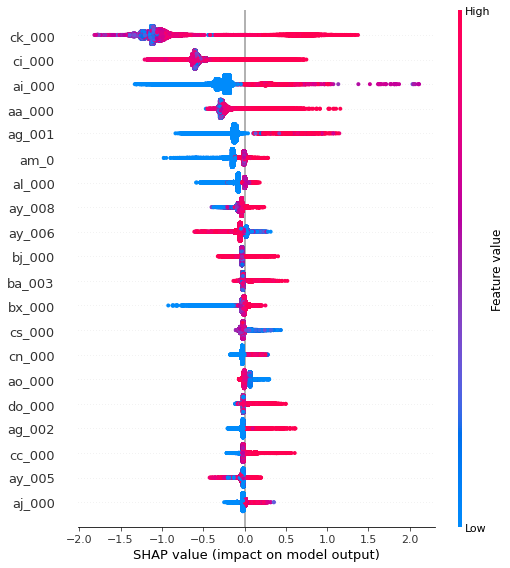

In [208]:
shap.summary_plot(shap_values[1],
                  pd.DataFrame(X,
                               columns=df_train.columns[1:]))

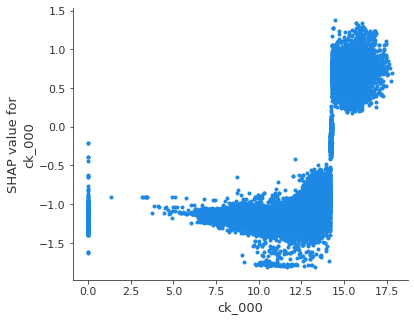

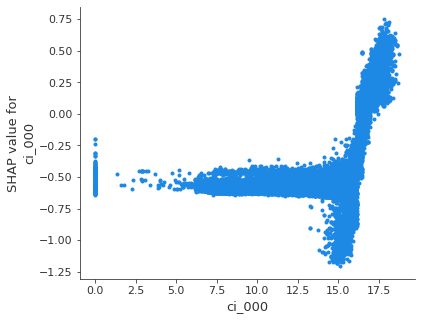

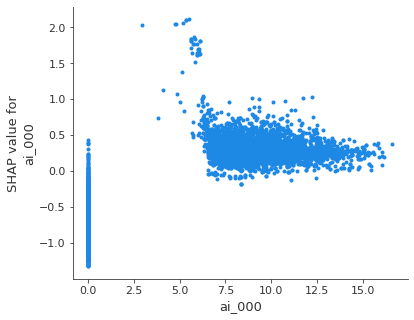

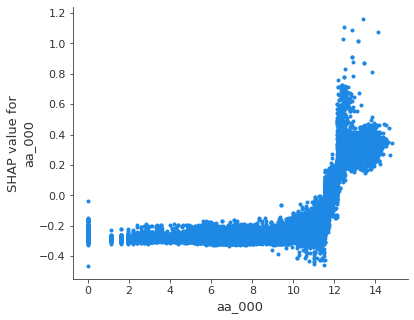

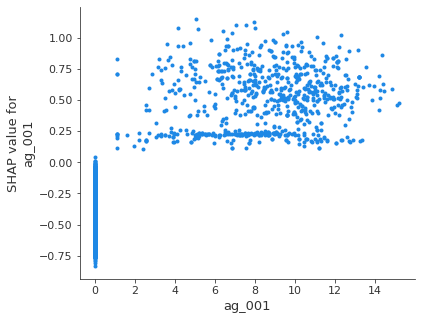

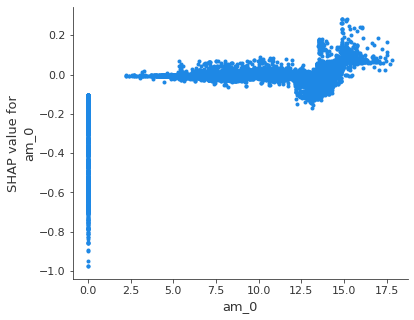

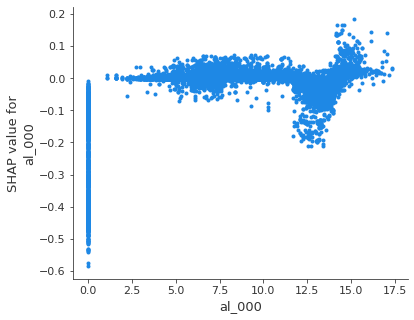

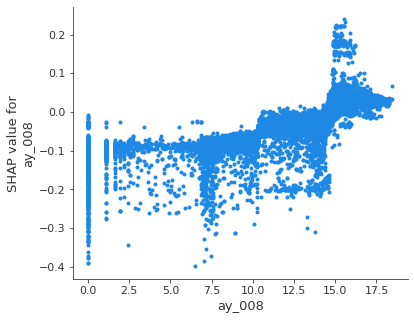

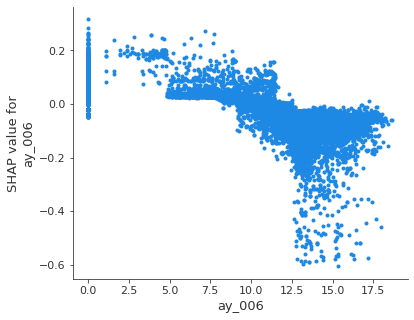

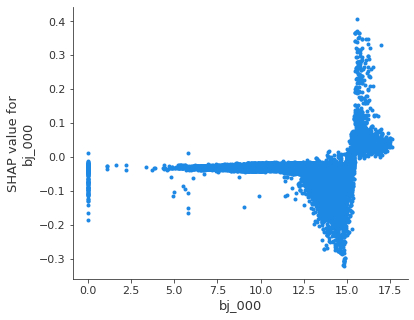

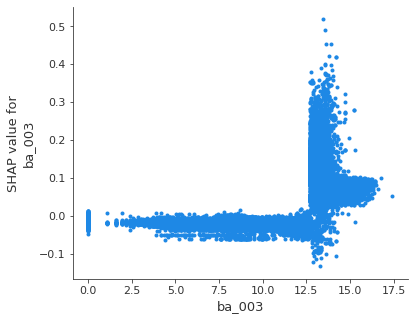

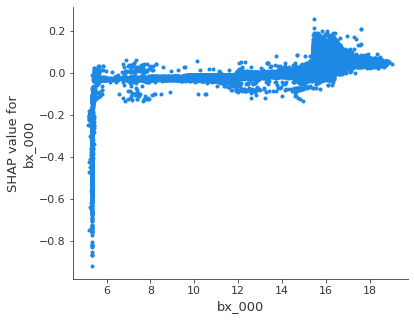

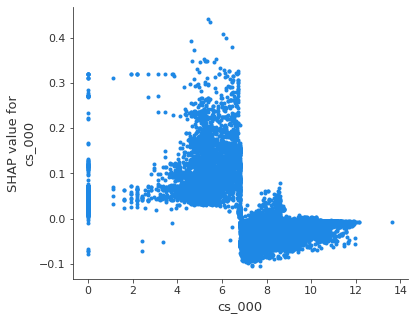

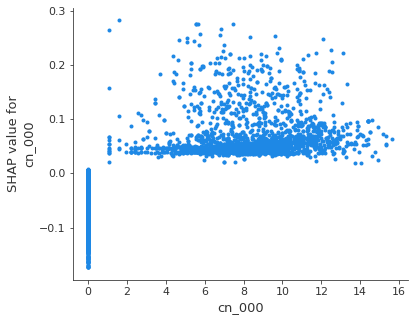

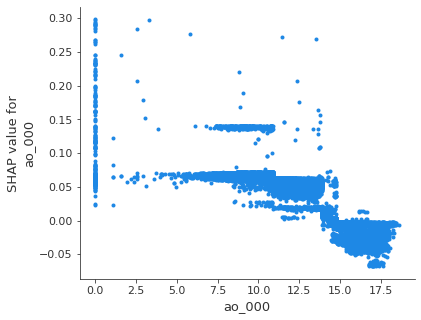

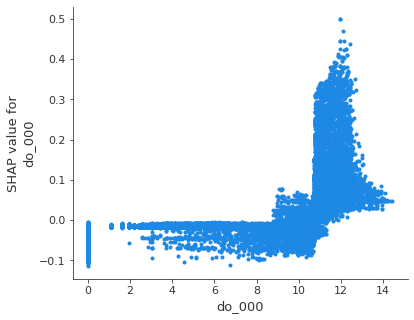

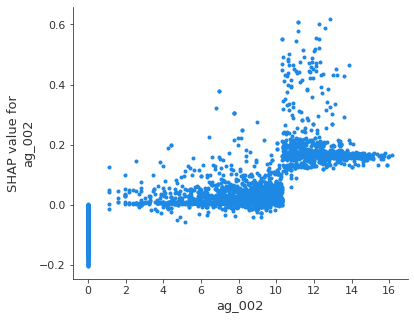

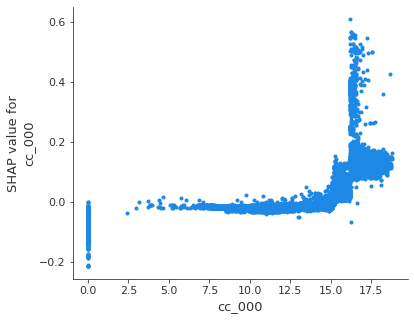

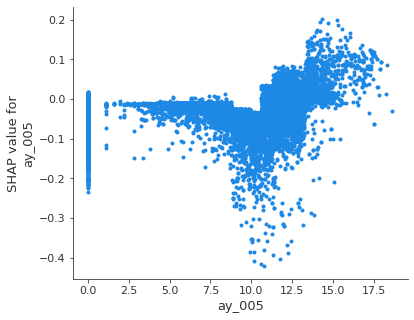

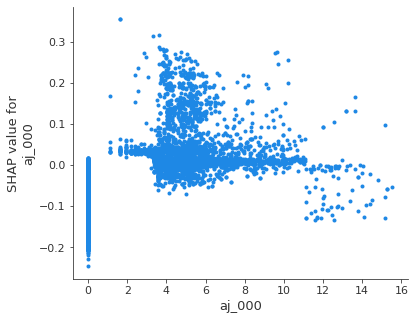

In [209]:
top_feats = ['ck_000','ci_000','ai_000','aa_000','ag_001',
             'am_0','al_000','ay_008','ay_006','bj_000',
             'ba_003','bx_000','cs_000','cn_000','ao_000',
             'do_000','ag_002','cc_000','ay_005','aj_000']
for feat in top_feats:
    shap.dependence_plot(feat, shap_values[1], pd.DataFrame(X, columns=df_train.columns[1:]), interaction_index=None)

In [214]:
np.random.seed(1)

kf_data = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_res3[top_feats], y=y_res3)

param_grid = {
    'num_leaves': [31,41,51],
    'min_data_in_leaf': [75, 100,125],
    'lambda_l1': [0.0001,0.001, 0.01],
    'lambda_l2': [0.1,1,10]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                   objective='binary',
                                   early_stopping_rounds=5,
                                   verbose=1,
                                   bagging_fraction=0.75,
                                   feature_fraction=0.75,
                                   num_boost_round=250,
                                   learning_rate=0.1,
                                   metric='auc')

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=kf_data)
lgb_model = gsearch.fit(X=X_res3[top_feats], y=y_res3, eval_set = (pd.DataFrame(X_test, columns=df_train.columns[1:])[top_feats], Y_test))

print(lgb_model.best_params_, lgb_model.best_score_)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.979075
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984227
[3]	valid_0's auc: 0.987304
[4]	valid_0's auc: 0.987763
[5]	valid_0's auc: 0.987993
[6]	valid_0's auc: 0.988147
[7]	valid_0's auc: 0.987967
[8]	valid_0's auc: 0.988567
[9]	valid_0's auc: 0.989589
[10]	valid_0's auc: 0.989699
[11]	valid_0's auc: 0.989625
[12]	valid_0's auc: 0.989583
[13]	valid_0's auc: 0.989503
[14]	valid_0's auc: 0.989614
[15]	valid_0's auc: 0.989715
[16]	valid_0's auc: 0.989796
[17]	valid_0's auc: 0.990068
[18]	valid_0's auc: 0.990236
[19]	valid_0's auc: 0.990275
[20]	valid_0's auc: 0.9903
[21]	valid_0's auc: 0.99027
[22]	valid_0's auc: 0.99021
[23]	valid_0's auc: 0.99029
[24]	valid_0's auc: 0.990236
[25]	valid_0's auc: 0.990381
[26]	valid_0's auc: 0.990281
[27]	valid_0's auc: 0.990485
[28]	valid_0's auc: 0.990555
[29]	valid_0's auc: 0.990115
[30]	valid_0's auc: 0.990166
[31]	valid_0's auc: 0.98994
[32]	valid_0's auc: 0.989898
[33]	valid_0's auc: 0.98986

[1]	valid_0's auc: 0.983208
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985606
[3]	valid_0's auc: 0.988244
[4]	valid_0's auc: 0.987845
[5]	valid_0's auc: 0.988233
[6]	valid_0's auc: 0.988538
[7]	valid_0's auc: 0.98855
[8]	valid_0's auc: 0.989114
[9]	valid_0's auc: 0.989566
[10]	valid_0's auc: 0.989381
[11]	valid_0's auc: 0.989449
[12]	valid_0's auc: 0.989439
[13]	valid_0's auc: 0.989435
[14]	valid_0's auc: 0.989713
[15]	valid_0's auc: 0.989064
[16]	valid_0's auc: 0.990137
[17]	valid_0's auc: 0.989956
[18]	valid_0's auc: 0.989904
[19]	valid_0's auc: 0.989122
[20]	valid_0's auc: 0.990085
[21]	valid_0's auc: 0.990078
Early stopping, best iteration is:
[16]	valid_0's auc: 0.990137
[1]	valid_0's auc: 0.983288
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984441
[3]	valid_0's auc: 0.987154
[4]	valid_0's auc: 0.987796
[5]	valid_0's auc: 0.988253
[6]	valid_0's auc: 0.98857
[7]	valid_0's auc: 0.988756
[8]	valid_0's auc: 0.9

[17]	valid_0's auc: 0.990043
[18]	valid_0's auc: 0.989829
[19]	valid_0's auc: 0.989959
[20]	valid_0's auc: 0.989886
[21]	valid_0's auc: 0.989681
[22]	valid_0's auc: 0.989693
Early stopping, best iteration is:
[17]	valid_0's auc: 0.990043
[1]	valid_0's auc: 0.983206
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984912
[3]	valid_0's auc: 0.987667
[4]	valid_0's auc: 0.987629
[5]	valid_0's auc: 0.987762
[6]	valid_0's auc: 0.987982
[7]	valid_0's auc: 0.988233
[8]	valid_0's auc: 0.988666
[9]	valid_0's auc: 0.989069
[10]	valid_0's auc: 0.989147
[11]	valid_0's auc: 0.989331
[12]	valid_0's auc: 0.988824
[13]	valid_0's auc: 0.988625
[14]	valid_0's auc: 0.988724
[15]	valid_0's auc: 0.989353
[16]	valid_0's auc: 0.990101
[17]	valid_0's auc: 0.99008
[18]	valid_0's auc: 0.990027
[19]	valid_0's auc: 0.990242
[20]	valid_0's auc: 0.990125
[21]	valid_0's auc: 0.98997
[22]	valid_0's auc: 0.989995
[23]	valid_0's auc: 0.990252
[24]	valid_0's auc: 0.990328
[25]	valid_0's au

[21]	valid_0's auc: 0.989973
[22]	valid_0's auc: 0.98992
[23]	valid_0's auc: 0.989626
[24]	valid_0's auc: 0.989565
Early stopping, best iteration is:
[19]	valid_0's auc: 0.99004
[1]	valid_0's auc: 0.982036
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984925
[3]	valid_0's auc: 0.987562
[4]	valid_0's auc: 0.987498
[5]	valid_0's auc: 0.987717
[6]	valid_0's auc: 0.987878
[7]	valid_0's auc: 0.987857
[8]	valid_0's auc: 0.987895
[9]	valid_0's auc: 0.988226
[10]	valid_0's auc: 0.988284
[11]	valid_0's auc: 0.988351
[12]	valid_0's auc: 0.988438
[13]	valid_0's auc: 0.988473
[14]	valid_0's auc: 0.988626
[15]	valid_0's auc: 0.988945
[16]	valid_0's auc: 0.988979
[17]	valid_0's auc: 0.988933
[18]	valid_0's auc: 0.989055
[19]	valid_0's auc: 0.989137
[20]	valid_0's auc: 0.989285
[21]	valid_0's auc: 0.989395
[22]	valid_0's auc: 0.989887
[23]	valid_0's auc: 0.990046
[24]	valid_0's auc: 0.989989
[25]	valid_0's auc: 0.990077
[26]	valid_0's auc: 0.989927
[27]	valid_0's au

[1]	valid_0's auc: 0.979744
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984375
[3]	valid_0's auc: 0.987182
[4]	valid_0's auc: 0.987835
[5]	valid_0's auc: 0.987948
[6]	valid_0's auc: 0.987909
[7]	valid_0's auc: 0.987735
[8]	valid_0's auc: 0.988287
[9]	valid_0's auc: 0.989337
[10]	valid_0's auc: 0.98942
[11]	valid_0's auc: 0.989439
[12]	valid_0's auc: 0.989526
[13]	valid_0's auc: 0.98951
[14]	valid_0's auc: 0.989666
[15]	valid_0's auc: 0.989761
[16]	valid_0's auc: 0.989753
[17]	valid_0's auc: 0.989765
[18]	valid_0's auc: 0.9901
[19]	valid_0's auc: 0.990117
[20]	valid_0's auc: 0.990143
[21]	valid_0's auc: 0.990076
[22]	valid_0's auc: 0.990036
[23]	valid_0's auc: 0.989925
[24]	valid_0's auc: 0.990002
[25]	valid_0's auc: 0.990062
Early stopping, best iteration is:
[20]	valid_0's auc: 0.990143
[1]	valid_0's auc: 0.982714
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984656
[3]	valid_0's auc: 0.987458
[4]	valid_0's auc: 0

[16]	valid_0's auc: 0.989721
Early stopping, best iteration is:
[11]	valid_0's auc: 0.989994
[1]	valid_0's auc: 0.985686
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985706
[3]	valid_0's auc: 0.988179
[4]	valid_0's auc: 0.988182
[5]	valid_0's auc: 0.988355
[6]	valid_0's auc: 0.988337
[7]	valid_0's auc: 0.988907
[8]	valid_0's auc: 0.989419
[9]	valid_0's auc: 0.989852
[10]	valid_0's auc: 0.989727
[11]	valid_0's auc: 0.989671
[12]	valid_0's auc: 0.989717
[13]	valid_0's auc: 0.989841
[14]	valid_0's auc: 0.989782
Early stopping, best iteration is:
[9]	valid_0's auc: 0.989852
[1]	valid_0's auc: 0.984888
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984909
[3]	valid_0's auc: 0.987793
[4]	valid_0's auc: 0.987618
[5]	valid_0's auc: 0.987981
[6]	valid_0's auc: 0.988163
[7]	valid_0's auc: 0.988272
[8]	valid_0's auc: 0.988885
[9]	valid_0's auc: 0.98942
[10]	valid_0's auc: 0.989423
[11]	valid_0's auc: 0.989533
[12]	valid_0's auc

[1]	valid_0's auc: 0.984763
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984736
[3]	valid_0's auc: 0.987646
[4]	valid_0's auc: 0.987757
[5]	valid_0's auc: 0.988008
[6]	valid_0's auc: 0.988086
[7]	valid_0's auc: 0.988284
[8]	valid_0's auc: 0.988935
[9]	valid_0's auc: 0.989309
[10]	valid_0's auc: 0.989297
[11]	valid_0's auc: 0.988996
[12]	valid_0's auc: 0.98913
[13]	valid_0's auc: 0.989185
[14]	valid_0's auc: 0.989252
Early stopping, best iteration is:
[9]	valid_0's auc: 0.989309
[1]	valid_0's auc: 0.984604
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985265
[3]	valid_0's auc: 0.988454
[4]	valid_0's auc: 0.987766
[5]	valid_0's auc: 0.987803
[6]	valid_0's auc: 0.987884
[7]	valid_0's auc: 0.988288
[8]	valid_0's auc: 0.988703
[9]	valid_0's auc: 0.989305
[10]	valid_0's auc: 0.98947
[11]	valid_0's auc: 0.989577
[12]	valid_0's auc: 0.989553
[13]	valid_0's auc: 0.989626
[14]	valid_0's auc: 0.989729
[15]	valid_0's auc: 0.989

[1]	valid_0's auc: 0.982035
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985019
[3]	valid_0's auc: 0.987365
[4]	valid_0's auc: 0.988045
[5]	valid_0's auc: 0.987445
[6]	valid_0's auc: 0.98759
[7]	valid_0's auc: 0.987896
[8]	valid_0's auc: 0.988918
[9]	valid_0's auc: 0.989033
[10]	valid_0's auc: 0.988859
[11]	valid_0's auc: 0.988856
[12]	valid_0's auc: 0.988961
[13]	valid_0's auc: 0.98911
[14]	valid_0's auc: 0.989179
[15]	valid_0's auc: 0.989354
[16]	valid_0's auc: 0.989512
[17]	valid_0's auc: 0.989571
[18]	valid_0's auc: 0.989691
[19]	valid_0's auc: 0.989681
[20]	valid_0's auc: 0.989695
[21]	valid_0's auc: 0.98942
[22]	valid_0's auc: 0.989372
[23]	valid_0's auc: 0.989258
[24]	valid_0's auc: 0.988291
[25]	valid_0's auc: 0.988187
Early stopping, best iteration is:
[20]	valid_0's auc: 0.989695
[1]	valid_0's auc: 0.982265
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983418
[3]	valid_0's auc: 0.987002
[4]	valid_0's auc: 

[1]	valid_0's auc: 0.983756
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985461
[3]	valid_0's auc: 0.986039
[4]	valid_0's auc: 0.987801
[5]	valid_0's auc: 0.988113
[6]	valid_0's auc: 0.98828
[7]	valid_0's auc: 0.988133
[8]	valid_0's auc: 0.988584
[9]	valid_0's auc: 0.988807
[10]	valid_0's auc: 0.988335
[11]	valid_0's auc: 0.98855
[12]	valid_0's auc: 0.988484
[13]	valid_0's auc: 0.988654
[14]	valid_0's auc: 0.988615
Early stopping, best iteration is:
[9]	valid_0's auc: 0.988807
[1]	valid_0's auc: 0.983741
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984813
[3]	valid_0's auc: 0.986946
[4]	valid_0's auc: 0.987301
[5]	valid_0's auc: 0.987471
[6]	valid_0's auc: 0.987339
[7]	valid_0's auc: 0.987464
[8]	valid_0's auc: 0.988258
[9]	valid_0's auc: 0.988809
[10]	valid_0's auc: 0.988689
[11]	valid_0's auc: 0.988776
[12]	valid_0's auc: 0.988967
[13]	valid_0's auc: 0.987967
[14]	valid_0's auc: 0.988284
[15]	valid_0's auc: 0.989

[1]	valid_0's auc: 0.978735
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980436
[3]	valid_0's auc: 0.984902
[4]	valid_0's auc: 0.986206
[5]	valid_0's auc: 0.986381
[6]	valid_0's auc: 0.986636
[7]	valid_0's auc: 0.98678
[8]	valid_0's auc: 0.987855
[9]	valid_0's auc: 0.988585
[10]	valid_0's auc: 0.988547
[11]	valid_0's auc: 0.98844
[12]	valid_0's auc: 0.988426
[13]	valid_0's auc: 0.988635
[14]	valid_0's auc: 0.988709
[15]	valid_0's auc: 0.988896
[16]	valid_0's auc: 0.989094
[17]	valid_0's auc: 0.989014
[18]	valid_0's auc: 0.988991
[19]	valid_0's auc: 0.989076
[20]	valid_0's auc: 0.988816
[21]	valid_0's auc: 0.988989
Early stopping, best iteration is:
[16]	valid_0's auc: 0.989094
[1]	valid_0's auc: 0.977413
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980261
[3]	valid_0's auc: 0.984559
[4]	valid_0's auc: 0.985782
[5]	valid_0's auc: 0.986481
[6]	valid_0's auc: 0.986331
[7]	valid_0's auc: 0.986361
[8]	valid_0's auc: 0.9

[30]	valid_0's auc: 0.990568
[31]	valid_0's auc: 0.99049
[32]	valid_0's auc: 0.990467
[33]	valid_0's auc: 0.990358
[34]	valid_0's auc: 0.990451
Early stopping, best iteration is:
[29]	valid_0's auc: 0.990598
[1]	valid_0's auc: 0.981214
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985071
[3]	valid_0's auc: 0.987341
[4]	valid_0's auc: 0.987472
[5]	valid_0's auc: 0.987523
[6]	valid_0's auc: 0.987828
[7]	valid_0's auc: 0.987353
[8]	valid_0's auc: 0.98801
[9]	valid_0's auc: 0.988424
[10]	valid_0's auc: 0.988351
[11]	valid_0's auc: 0.988462
[12]	valid_0's auc: 0.988478
[13]	valid_0's auc: 0.988569
[14]	valid_0's auc: 0.988699
[15]	valid_0's auc: 0.98882
[16]	valid_0's auc: 0.98894
[17]	valid_0's auc: 0.988945
[18]	valid_0's auc: 0.988963
[19]	valid_0's auc: 0.989141
[20]	valid_0's auc: 0.989291
[21]	valid_0's auc: 0.989149
[22]	valid_0's auc: 0.989117
[23]	valid_0's auc: 0.989063
[24]	valid_0's auc: 0.989061
[25]	valid_0's auc: 0.989229
Early stopping, bes

[32]	valid_0's auc: 0.991246
Early stopping, best iteration is:
[27]	valid_0's auc: 0.991367
[1]	valid_0's auc: 0.981969
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982831
[3]	valid_0's auc: 0.985542
[4]	valid_0's auc: 0.985689
[5]	valid_0's auc: 0.985899
[6]	valid_0's auc: 0.986189
[7]	valid_0's auc: 0.986444
[8]	valid_0's auc: 0.987184
[9]	valid_0's auc: 0.988182
[10]	valid_0's auc: 0.98822
[11]	valid_0's auc: 0.988512
[12]	valid_0's auc: 0.988674
[13]	valid_0's auc: 0.988755
[14]	valid_0's auc: 0.988987
[15]	valid_0's auc: 0.988898
[16]	valid_0's auc: 0.989008
[17]	valid_0's auc: 0.98906
[18]	valid_0's auc: 0.989191
[19]	valid_0's auc: 0.989277
[20]	valid_0's auc: 0.98934
[21]	valid_0's auc: 0.989301
[22]	valid_0's auc: 0.989325
[23]	valid_0's auc: 0.989431
[24]	valid_0's auc: 0.98951
[25]	valid_0's auc: 0.98953
[26]	valid_0's auc: 0.99119
[27]	valid_0's auc: 0.991106
[28]	valid_0's auc: 0.991099
[29]	valid_0's auc: 0.991149
[30]	valid_0's auc: 0

[5]	valid_0's auc: 0.987233
[6]	valid_0's auc: 0.987172
[7]	valid_0's auc: 0.987128
[8]	valid_0's auc: 0.987709
[9]	valid_0's auc: 0.988345
[10]	valid_0's auc: 0.988268
[11]	valid_0's auc: 0.988416
[12]	valid_0's auc: 0.988504
[13]	valid_0's auc: 0.988555
[14]	valid_0's auc: 0.988694
[15]	valid_0's auc: 0.988865
[16]	valid_0's auc: 0.988968
[17]	valid_0's auc: 0.989041
[18]	valid_0's auc: 0.989016
[19]	valid_0's auc: 0.989276
[20]	valid_0's auc: 0.989107
[21]	valid_0's auc: 0.989269
[22]	valid_0's auc: 0.989293
[23]	valid_0's auc: 0.989257
[24]	valid_0's auc: 0.98942
[25]	valid_0's auc: 0.989509
[26]	valid_0's auc: 0.99117
[27]	valid_0's auc: 0.991009
[28]	valid_0's auc: 0.990988
[29]	valid_0's auc: 0.99108
[30]	valid_0's auc: 0.991083
[31]	valid_0's auc: 0.990949
Early stopping, best iteration is:
[26]	valid_0's auc: 0.99117
[1]	valid_0's auc: 0.982173
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982932
[3]	valid_0's auc: 0.986241
[4]	valid_0's auc:

[1]	valid_0's auc: 0.982153
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98288
[3]	valid_0's auc: 0.986303
[4]	valid_0's auc: 0.985794
[5]	valid_0's auc: 0.986234
[6]	valid_0's auc: 0.986397
[7]	valid_0's auc: 0.986647
[8]	valid_0's auc: 0.987779
[9]	valid_0's auc: 0.988478
[10]	valid_0's auc: 0.988346
[11]	valid_0's auc: 0.988423
[12]	valid_0's auc: 0.988487
[13]	valid_0's auc: 0.988702
[14]	valid_0's auc: 0.988802
[15]	valid_0's auc: 0.988769
[16]	valid_0's auc: 0.988922
[17]	valid_0's auc: 0.989165
[18]	valid_0's auc: 0.989257
[19]	valid_0's auc: 0.989396
[20]	valid_0's auc: 0.989358
[21]	valid_0's auc: 0.989318
[22]	valid_0's auc: 0.989307
[23]	valid_0's auc: 0.990273
[24]	valid_0's auc: 0.990335
[25]	valid_0's auc: 0.99043
[26]	valid_0's auc: 0.991183
[27]	valid_0's auc: 0.991185
[28]	valid_0's auc: 0.99119
[29]	valid_0's auc: 0.991153
[30]	valid_0's auc: 0.991048
[31]	valid_0's auc: 0.991008
[32]	valid_0's auc: 0.990954
[33]	valid_0's auc: 0.99

[12]	valid_0's auc: 0.989505
[13]	valid_0's auc: 0.989622
[14]	valid_0's auc: 0.989589
[15]	valid_0's auc: 0.989716
[16]	valid_0's auc: 0.98971
[17]	valid_0's auc: 0.989807
[18]	valid_0's auc: 0.989931
[19]	valid_0's auc: 0.990055
[20]	valid_0's auc: 0.989711
[21]	valid_0's auc: 0.989586
[22]	valid_0's auc: 0.989617
[23]	valid_0's auc: 0.989598
[24]	valid_0's auc: 0.989446
Early stopping, best iteration is:
[19]	valid_0's auc: 0.990055
[1]	valid_0's auc: 0.982272
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984397
[3]	valid_0's auc: 0.986788
[4]	valid_0's auc: 0.987107
[5]	valid_0's auc: 0.987044
[6]	valid_0's auc: 0.987375
[7]	valid_0's auc: 0.987404
[8]	valid_0's auc: 0.988988
[9]	valid_0's auc: 0.989281
[10]	valid_0's auc: 0.989262
[11]	valid_0's auc: 0.989065
[12]	valid_0's auc: 0.989149
[13]	valid_0's auc: 0.989101
[14]	valid_0's auc: 0.989409
[15]	valid_0's auc: 0.989597
[16]	valid_0's auc: 0.989564
[17]	valid_0's auc: 0.989481
[18]	valid_0's a

[1]	valid_0's auc: 0.979442
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98398
[3]	valid_0's auc: 0.987067
[4]	valid_0's auc: 0.98765
[5]	valid_0's auc: 0.987502
[6]	valid_0's auc: 0.987803
[7]	valid_0's auc: 0.987968
[8]	valid_0's auc: 0.988335
[9]	valid_0's auc: 0.98713
[10]	valid_0's auc: 0.987074
[11]	valid_0's auc: 0.987267
[12]	valid_0's auc: 0.987142
[13]	valid_0's auc: 0.987175
Early stopping, best iteration is:
[8]	valid_0's auc: 0.988335
[1]	valid_0's auc: 0.980237
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983121
[3]	valid_0's auc: 0.986325
[4]	valid_0's auc: 0.98728
[5]	valid_0's auc: 0.987211
[6]	valid_0's auc: 0.987329
[7]	valid_0's auc: 0.987702
[8]	valid_0's auc: 0.989055
[9]	valid_0's auc: 0.989316
[10]	valid_0's auc: 0.989425
[11]	valid_0's auc: 0.989243
[12]	valid_0's auc: 0.989227
[13]	valid_0's auc: 0.989125
[14]	valid_0's auc: 0.989281
[15]	valid_0's auc: 0.989544
[16]	valid_0's auc: 0.9896


[5]	valid_0's auc: 0.988384
[6]	valid_0's auc: 0.988689
[7]	valid_0's auc: 0.988938
[8]	valid_0's auc: 0.988662
[9]	valid_0's auc: 0.988981
[10]	valid_0's auc: 0.987648
[11]	valid_0's auc: 0.989644
[12]	valid_0's auc: 0.989539
[13]	valid_0's auc: 0.989297
[14]	valid_0's auc: 0.989526
[15]	valid_0's auc: 0.990777
[16]	valid_0's auc: 0.990857
[17]	valid_0's auc: 0.990615
[18]	valid_0's auc: 0.990654
[19]	valid_0's auc: 0.990743
[20]	valid_0's auc: 0.990657
[21]	valid_0's auc: 0.990815
Early stopping, best iteration is:
[16]	valid_0's auc: 0.990857
[1]	valid_0's auc: 0.984635
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984979
[3]	valid_0's auc: 0.987727
[4]	valid_0's auc: 0.987972
[5]	valid_0's auc: 0.988051
[6]	valid_0's auc: 0.987919
[7]	valid_0's auc: 0.988584
[8]	valid_0's auc: 0.989208
[9]	valid_0's auc: 0.989469
[10]	valid_0's auc: 0.988843
[11]	valid_0's auc: 0.988781
[12]	valid_0's auc: 0.988712
[13]	valid_0's auc: 0.988706
[14]	valid_0's auc: 

[20]	valid_0's auc: 0.989686
[21]	valid_0's auc: 0.989662
[22]	valid_0's auc: 0.989644
[23]	valid_0's auc: 0.990737
[24]	valid_0's auc: 0.990651
[25]	valid_0's auc: 0.990182
[26]	valid_0's auc: 0.990309
[27]	valid_0's auc: 0.990211
[28]	valid_0's auc: 0.990417
Early stopping, best iteration is:
[23]	valid_0's auc: 0.990737
[1]	valid_0's auc: 0.983412
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985272
[3]	valid_0's auc: 0.987667
[4]	valid_0's auc: 0.98762
[5]	valid_0's auc: 0.987673
[6]	valid_0's auc: 0.987953
[7]	valid_0's auc: 0.988528
[8]	valid_0's auc: 0.989279
[9]	valid_0's auc: 0.989753
[10]	valid_0's auc: 0.989424
[11]	valid_0's auc: 0.98951
[12]	valid_0's auc: 0.989138
[13]	valid_0's auc: 0.98905
[14]	valid_0's auc: 0.989211
Early stopping, best iteration is:
[9]	valid_0's auc: 0.989753
[1]	valid_0's auc: 0.982501
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983753
[3]	valid_0's auc: 0.986118
[4]	valid_0's 

[14]	valid_0's auc: 0.989575
Early stopping, best iteration is:
[9]	valid_0's auc: 0.989601
[1]	valid_0's auc: 0.983891
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984519
[3]	valid_0's auc: 0.986835
[4]	valid_0's auc: 0.987265
[5]	valid_0's auc: 0.987314
[6]	valid_0's auc: 0.987161
[7]	valid_0's auc: 0.987228
[8]	valid_0's auc: 0.988859
[9]	valid_0's auc: 0.989418
[10]	valid_0's auc: 0.989421
[11]	valid_0's auc: 0.989688
[12]	valid_0's auc: 0.989597
[13]	valid_0's auc: 0.989685
[14]	valid_0's auc: 0.989619
[15]	valid_0's auc: 0.989803
[16]	valid_0's auc: 0.989839
[17]	valid_0's auc: 0.989975
[18]	valid_0's auc: 0.989945
[19]	valid_0's auc: 0.990034
[20]	valid_0's auc: 0.989791
[21]	valid_0's auc: 0.989767
[22]	valid_0's auc: 0.989763
[23]	valid_0's auc: 0.989742
[24]	valid_0's auc: 0.989896
Early stopping, best iteration is:
[19]	valid_0's auc: 0.990034
[1]	valid_0's auc: 0.982611
Training until validation scores don't improve for 5 rounds
[2]	valid

[10]	valid_0's auc: 0.989165
[11]	valid_0's auc: 0.989355
[12]	valid_0's auc: 0.989369
[13]	valid_0's auc: 0.989336
[14]	valid_0's auc: 0.98956
[15]	valid_0's auc: 0.99045
[16]	valid_0's auc: 0.990476
[17]	valid_0's auc: 0.98978
[18]	valid_0's auc: 0.990363
[19]	valid_0's auc: 0.990517
[20]	valid_0's auc: 0.990716
[21]	valid_0's auc: 0.990707
[22]	valid_0's auc: 0.990705
[23]	valid_0's auc: 0.990608
[24]	valid_0's auc: 0.990746
[25]	valid_0's auc: 0.99083
[26]	valid_0's auc: 0.990388
[27]	valid_0's auc: 0.990049
[28]	valid_0's auc: 0.990086
[29]	valid_0's auc: 0.990143
[30]	valid_0's auc: 0.990173
Early stopping, best iteration is:
[25]	valid_0's auc: 0.99083
[1]	valid_0's auc: 0.9801
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984491
[3]	valid_0's auc: 0.987318
[4]	valid_0's auc: 0.9876
[5]	valid_0's auc: 0.987724
[6]	valid_0's auc: 0.987991
[7]	valid_0's auc: 0.988157
[8]	valid_0's auc: 0.988674
[9]	valid_0's auc: 0.988955
[10]	valid_0's auc: 0.98

[1]	valid_0's auc: 0.981381
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983133
[3]	valid_0's auc: 0.987013
[4]	valid_0's auc: 0.987212
[5]	valid_0's auc: 0.987381
[6]	valid_0's auc: 0.987732
[7]	valid_0's auc: 0.987964
[8]	valid_0's auc: 0.988769
[9]	valid_0's auc: 0.989125
[10]	valid_0's auc: 0.989044
[11]	valid_0's auc: 0.988985
[12]	valid_0's auc: 0.989026
[13]	valid_0's auc: 0.989156
[14]	valid_0's auc: 0.989238
[15]	valid_0's auc: 0.989077
[16]	valid_0's auc: 0.989163
[17]	valid_0's auc: 0.989108
[18]	valid_0's auc: 0.989172
[19]	valid_0's auc: 0.98932
[20]	valid_0's auc: 0.989337
[21]	valid_0's auc: 0.988991
[22]	valid_0's auc: 0.989931
[23]	valid_0's auc: 0.989951
[24]	valid_0's auc: 0.989972
[25]	valid_0's auc: 0.990071
[26]	valid_0's auc: 0.990186
[27]	valid_0's auc: 0.990088
[28]	valid_0's auc: 0.990343
[29]	valid_0's auc: 0.989956
[30]	valid_0's auc: 0.989922
[31]	valid_0's auc: 0.989858
[32]	valid_0's auc: 0.990032
[33]	valid_0's auc: 0.

[15]	valid_0's auc: 0.98972
[16]	valid_0's auc: 0.989742
[17]	valid_0's auc: 0.989855
[18]	valid_0's auc: 0.989928
[19]	valid_0's auc: 0.989876
[20]	valid_0's auc: 0.989562
[21]	valid_0's auc: 0.989594
[22]	valid_0's auc: 0.989552
[23]	valid_0's auc: 0.989441
Early stopping, best iteration is:
[18]	valid_0's auc: 0.989928
[1]	valid_0's auc: 0.982408
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985137
[3]	valid_0's auc: 0.987676
[4]	valid_0's auc: 0.987714
[5]	valid_0's auc: 0.987835
[6]	valid_0's auc: 0.988112
[7]	valid_0's auc: 0.988004
[8]	valid_0's auc: 0.98861
[9]	valid_0's auc: 0.988669
[10]	valid_0's auc: 0.988698
[11]	valid_0's auc: 0.988715
[12]	valid_0's auc: 0.988885
[13]	valid_0's auc: 0.988932
[14]	valid_0's auc: 0.98911
[15]	valid_0's auc: 0.989013
[16]	valid_0's auc: 0.989056
[17]	valid_0's auc: 0.989025
[18]	valid_0's auc: 0.989189
[19]	valid_0's auc: 0.989236
[20]	valid_0's auc: 0.989139
[21]	valid_0's auc: 0.989151
[22]	valid_0's auc

[17]	valid_0's auc: 0.991129
[18]	valid_0's auc: 0.99112
[19]	valid_0's auc: 0.991219
[20]	valid_0's auc: 0.991419
[21]	valid_0's auc: 0.991418
[22]	valid_0's auc: 0.991313
[23]	valid_0's auc: 0.991227
[24]	valid_0's auc: 0.991164
[25]	valid_0's auc: 0.991067
Early stopping, best iteration is:
[20]	valid_0's auc: 0.991419
[1]	valid_0's auc: 0.983219
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984517
[3]	valid_0's auc: 0.986147
[4]	valid_0's auc: 0.986377
[5]	valid_0's auc: 0.988417
[6]	valid_0's auc: 0.988471
[7]	valid_0's auc: 0.986835
[8]	valid_0's auc: 0.987711
[9]	valid_0's auc: 0.987554
[10]	valid_0's auc: 0.987432
[11]	valid_0's auc: 0.989183
[12]	valid_0's auc: 0.989264
[13]	valid_0's auc: 0.989105
[14]	valid_0's auc: 0.989143
[15]	valid_0's auc: 0.99003
[16]	valid_0's auc: 0.989884
[17]	valid_0's auc: 0.989808
[18]	valid_0's auc: 0.989839
[19]	valid_0's auc: 0.989919
[20]	valid_0's auc: 0.989832
Early stopping, best iteration is:
[15]	valid_

[1]	valid_0's auc: 0.977639
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.979632
[3]	valid_0's auc: 0.98484
[4]	valid_0's auc: 0.985228
[5]	valid_0's auc: 0.985852
[6]	valid_0's auc: 0.98589
[7]	valid_0's auc: 0.986162
[8]	valid_0's auc: 0.987393
[9]	valid_0's auc: 0.988279
[10]	valid_0's auc: 0.988235
[11]	valid_0's auc: 0.988394
[12]	valid_0's auc: 0.988591
[13]	valid_0's auc: 0.98876
[14]	valid_0's auc: 0.988891
[15]	valid_0's auc: 0.989204
[16]	valid_0's auc: 0.989315
[17]	valid_0's auc: 0.989355
[18]	valid_0's auc: 0.98971
[19]	valid_0's auc: 0.989804
[20]	valid_0's auc: 0.989583
[21]	valid_0's auc: 0.98955
[22]	valid_0's auc: 0.989514
[23]	valid_0's auc: 0.989537
[24]	valid_0's auc: 0.989505
Early stopping, best iteration is:
[19]	valid_0's auc: 0.989804
[1]	valid_0's auc: 0.979871
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.980911
[3]	valid_0's auc: 0.985039
[4]	valid_0's auc: 0.985613
[5]	valid_0's auc: 0.9

[24]	valid_0's auc: 0.990646
[25]	valid_0's auc: 0.990522
[26]	valid_0's auc: 0.990599
[27]	valid_0's auc: 0.990572
[28]	valid_0's auc: 0.990605
[29]	valid_0's auc: 0.99071
[30]	valid_0's auc: 0.990748
[31]	valid_0's auc: 0.990651
[32]	valid_0's auc: 0.990575
[33]	valid_0's auc: 0.990415
[34]	valid_0's auc: 0.990544
[35]	valid_0's auc: 0.990536
Early stopping, best iteration is:
[30]	valid_0's auc: 0.990748
[1]	valid_0's auc: 0.981216
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984464
[3]	valid_0's auc: 0.986452
[4]	valid_0's auc: 0.986145
[5]	valid_0's auc: 0.986651
[6]	valid_0's auc: 0.986677
[7]	valid_0's auc: 0.986507
[8]	valid_0's auc: 0.987528
[9]	valid_0's auc: 0.98815
[10]	valid_0's auc: 0.988178
[11]	valid_0's auc: 0.988412
[12]	valid_0's auc: 0.988406
[13]	valid_0's auc: 0.988558
[14]	valid_0's auc: 0.988647
[15]	valid_0's auc: 0.988436
[16]	valid_0's auc: 0.988557
[17]	valid_0's auc: 0.988622
[18]	valid_0's auc: 0.988744
[19]	valid_0's au

[37]	valid_0's auc: 0.990493
Early stopping, best iteration is:
[32]	valid_0's auc: 0.990992
[1]	valid_0's auc: 0.982184
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98267
[3]	valid_0's auc: 0.985851
[4]	valid_0's auc: 0.98609
[5]	valid_0's auc: 0.986186
[6]	valid_0's auc: 0.986394
[7]	valid_0's auc: 0.98639
[8]	valid_0's auc: 0.987269
[9]	valid_0's auc: 0.988373
[10]	valid_0's auc: 0.988228
[11]	valid_0's auc: 0.987968
[12]	valid_0's auc: 0.988069
[13]	valid_0's auc: 0.988448
[14]	valid_0's auc: 0.988698
[15]	valid_0's auc: 0.988989
[16]	valid_0's auc: 0.989114
[17]	valid_0's auc: 0.989076
[18]	valid_0's auc: 0.989276
[19]	valid_0's auc: 0.989432
[20]	valid_0's auc: 0.98916
[21]	valid_0's auc: 0.989317
[22]	valid_0's auc: 0.989355
[23]	valid_0's auc: 0.989372
[24]	valid_0's auc: 0.989399
Early stopping, best iteration is:
[19]	valid_0's auc: 0.989432
[1]	valid_0's auc: 0.982189
Training until validation scores don't improve for 5 rounds
[2]	valid_0'

[3]	valid_0's auc: 0.98667
[4]	valid_0's auc: 0.987219
[5]	valid_0's auc: 0.987569
[6]	valid_0's auc: 0.987795
[7]	valid_0's auc: 0.988324
[8]	valid_0's auc: 0.988949
[9]	valid_0's auc: 0.987466
[10]	valid_0's auc: 0.98739
[11]	valid_0's auc: 0.987392
[12]	valid_0's auc: 0.987496
[13]	valid_0's auc: 0.987628
Early stopping, best iteration is:
[8]	valid_0's auc: 0.988949
[1]	valid_0's auc: 0.984012
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.985372
[3]	valid_0's auc: 0.987577
[4]	valid_0's auc: 0.987327
[5]	valid_0's auc: 0.987663
[6]	valid_0's auc: 0.987857
[7]	valid_0's auc: 0.988518
[8]	valid_0's auc: 0.989241
[9]	valid_0's auc: 0.989703
[10]	valid_0's auc: 0.989642
[11]	valid_0's auc: 0.989594
[12]	valid_0's auc: 0.989691
[13]	valid_0's auc: 0.989809
[14]	valid_0's auc: 0.989635
[15]	valid_0's auc: 0.989246
[16]	valid_0's auc: 0.989265
[17]	valid_0's auc: 0.989378
[18]	valid_0's auc: 0.989449
Early stopping, best iteration is:
[13]	valid_0's auc:

[28]	valid_0's auc: 0.991909
[29]	valid_0's auc: 0.991914
[30]	valid_0's auc: 0.991984
[31]	valid_0's auc: 0.991882
[32]	valid_0's auc: 0.991952
[33]	valid_0's auc: 0.991948
[34]	valid_0's auc: 0.991906
[35]	valid_0's auc: 0.991762
Early stopping, best iteration is:
[30]	valid_0's auc: 0.991984
[1]	valid_0's auc: 0.982184
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.983418
[3]	valid_0's auc: 0.986392
[4]	valid_0's auc: 0.986912
[5]	valid_0's auc: 0.987044
[6]	valid_0's auc: 0.986963
[7]	valid_0's auc: 0.987004
[8]	valid_0's auc: 0.988633
[9]	valid_0's auc: 0.989268
[10]	valid_0's auc: 0.989282
[11]	valid_0's auc: 0.989457
[12]	valid_0's auc: 0.989499
[13]	valid_0's auc: 0.989462
[14]	valid_0's auc: 0.989545
[15]	valid_0's auc: 0.989711
[16]	valid_0's auc: 0.989626
[17]	valid_0's auc: 0.989819
[18]	valid_0's auc: 0.989937
[19]	valid_0's auc: 0.990037
[20]	valid_0's auc: 0.989796
[21]	valid_0's auc: 0.989798
[22]	valid_0's auc: 0.989933
[23]	valid_0's 

[17]	valid_0's auc: 0.989572
[18]	valid_0's auc: 0.990043
[19]	valid_0's auc: 0.990128
[20]	valid_0's auc: 0.99101
[21]	valid_0's auc: 0.99087
[22]	valid_0's auc: 0.990821
[23]	valid_0's auc: 0.99093
[24]	valid_0's auc: 0.990826
[25]	valid_0's auc: 0.990746
Early stopping, best iteration is:
[20]	valid_0's auc: 0.99101
[1]	valid_0's auc: 0.983182
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984139
[3]	valid_0's auc: 0.987457
[4]	valid_0's auc: 0.987494
[5]	valid_0's auc: 0.987595
[6]	valid_0's auc: 0.987929
[7]	valid_0's auc: 0.986389
[8]	valid_0's auc: 0.987197
[9]	valid_0's auc: 0.987613
[10]	valid_0's auc: 0.987355
[11]	valid_0's auc: 0.987415
Early stopping, best iteration is:
[6]	valid_0's auc: 0.987929
[1]	valid_0's auc: 0.980987
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.98423
[3]	valid_0's auc: 0.987619
[4]	valid_0's auc: 0.987866
[5]	valid_0's auc: 0.987696
[6]	valid_0's auc: 0.987635
[7]	valid_0's auc: 

[1]	valid_0's auc: 0.983526
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.984383
[3]	valid_0's auc: 0.987456
[4]	valid_0's auc: 0.987448
[5]	valid_0's auc: 0.987942
[6]	valid_0's auc: 0.987935
[7]	valid_0's auc: 0.988207
[8]	valid_0's auc: 0.988545
[9]	valid_0's auc: 0.988989
[10]	valid_0's auc: 0.988869
[11]	valid_0's auc: 0.988916
[12]	valid_0's auc: 0.988926
[13]	valid_0's auc: 0.988989
[14]	valid_0's auc: 0.989069
[15]	valid_0's auc: 0.990249
[16]	valid_0's auc: 0.990312
[17]	valid_0's auc: 0.990202
[18]	valid_0's auc: 0.990361
[19]	valid_0's auc: 0.990393
[20]	valid_0's auc: 0.99027
[21]	valid_0's auc: 0.990205
[22]	valid_0's auc: 0.990128
[23]	valid_0's auc: 0.990681
[24]	valid_0's auc: 0.990627
[25]	valid_0's auc: 0.990531
[26]	valid_0's auc: 0.990493
[27]	valid_0's auc: 0.990417
[28]	valid_0's auc: 0.990534
Early stopping, best iteration is:
[23]	valid_0's auc: 0.990681
[1]	valid_0's auc: 0.984052
Training until validation scores don't improve

KeyboardInterrupt: 

In [ ]:
# # use the balanced dataset
# X_res3.columns=df_train.columns[1:]

# np.random.seed(1)

# kf_data = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_res3[top_feats], y=y_res3)

# param_grid = {
#     'num_leaves': [41,51],
#     'min_data_in_leaf': [75, 100,125],
#     'lambda_l1': [0.0001],
#     'lambda_l2': [0.1,1,10]
#     }

# lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
#                                    objective='binary',
#                                    num_boost_round=250,
#                                    learning_rate=0.1,
#                                    metric='auc')

# gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=kf_data)
# lgb_model = gsearch.fit(X=X_res3[top_feats], y=y_res3)

# print(lgb_model.best_params_, lgb_model.best_score_)